In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc
import scipy
import warnings
from tqdm.notebook import tqdm
import pickle as pkl
from matplotlib.patches import Polygon

import matplotlib as mpl
import seaborn as sns

In [109]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

## Reading in Data

In [110]:
exps = dict()
for exp in range(5):
    exps[exp] = dict()

In [111]:
exps[0]['path'] = '../../../../data/h5_data/20180831_L10C.h5ad'
exps[1]['path'] = '../../../../data/h5_data/20190920_L20C1.h5ad'
exps[2]['path'] = '../../../../data/h5_data/20190920_L20T.h5ad'
exps[3]['path'] = '../../../../data/h5_data/20180831_L30C.h5ad'
exps[4]['path'] = '../../../../data/h5_data/20180831_L30C8.h5ad'

In [112]:
for exp in exps:
    exps[exp]['adata'] = sc.read_h5ad(exps[exp]['path'])

In [113]:
for exp in exps:
    exps[exp]['label'] = exps[exp]['path'].split('/')[-1]

## Filtering for Cells, Labeling Human and Mouse Cells

In [114]:
# for exp in exps:
#     exps[exp]['adata'] = exps[exp]['adata'][np.unique(np.concatenate([exps[exp]['adata_human'].obs_names.values, exps[exp]['adata_mouse'].obs_names.values],axis=0))].copy()

In [115]:
adata = exps[0]['adata'].concatenate(exps[1]['adata'],exps[2]['adata'],exps[3]['adata'],exps[4]['adata'], join='inner').copy()

In [116]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)

adata.obs['log_counts'] = np.log(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [117]:
adata.obs['barcode'] = adata.obs.index.str[-18:-2]

In [118]:
adata.var_names_make_unique()

In [119]:
#sc.pl.highest_expr_genes(adata, n_top=100) 

In [120]:
mito_genes_mouse=[name for name in adata.var_names if name.startswith(('mm10_mt-'))]
                                                              
#mito_genes_human=[name for name in adata.var_names if name.startswith(('hg19_MT-'))] 

adata.obs['percent_mito_mouse'] = np.sum(adata[:, mito_genes_mouse].X, axis=1) / np.sum(adata.X, axis=1)*100

#adata.obs['percent_mito_human'] = np.sum(adata[:, mito_genes_human].X, axis=1) / np.sum(adata.X, axis=1)*100

In [121]:
sc.pp.filter_cells(adata, min_counts = 500)
sc.pp.filter_cells(adata, min_genes = 100)

filtered out 53144 cells that have less than 500 counts
filtered out 176 cells that have less than 100 genes expressed


In [122]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 66126 genes that are detected in less than 1 cells


In [123]:
#adata.var.sort_values(by='n_cells')[::-1].head(n=10)

In [124]:
#sc.pp.filter_genes(adata, max_cells=15000) 

In [125]:
adata = adata[adata.obs['n_counts'] < 10000, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [126]:
adata.obs['batch'].value_counts()

1    7151
2    6888
3    1795
0    1587
4     944
Name: batch, dtype: int64

In [127]:
adata = adata[adata.obs['percent_mito_mouse'] < 1, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [128]:
adata.obs['batch'].value_counts()

1    4788
2    2950
3    1146
0     826
4     570
Name: batch, dtype: int64

In [129]:
#barnyard


mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
#human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]

human_genes=[name for name in adata.var_names if name.startswith('hg19')]


adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [130]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

         
adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)

adata.obs['cell_call'] = adata.obs['cell_call'].astype('category')


In [131]:
np.log10(0.66)

-0.1804560644581313

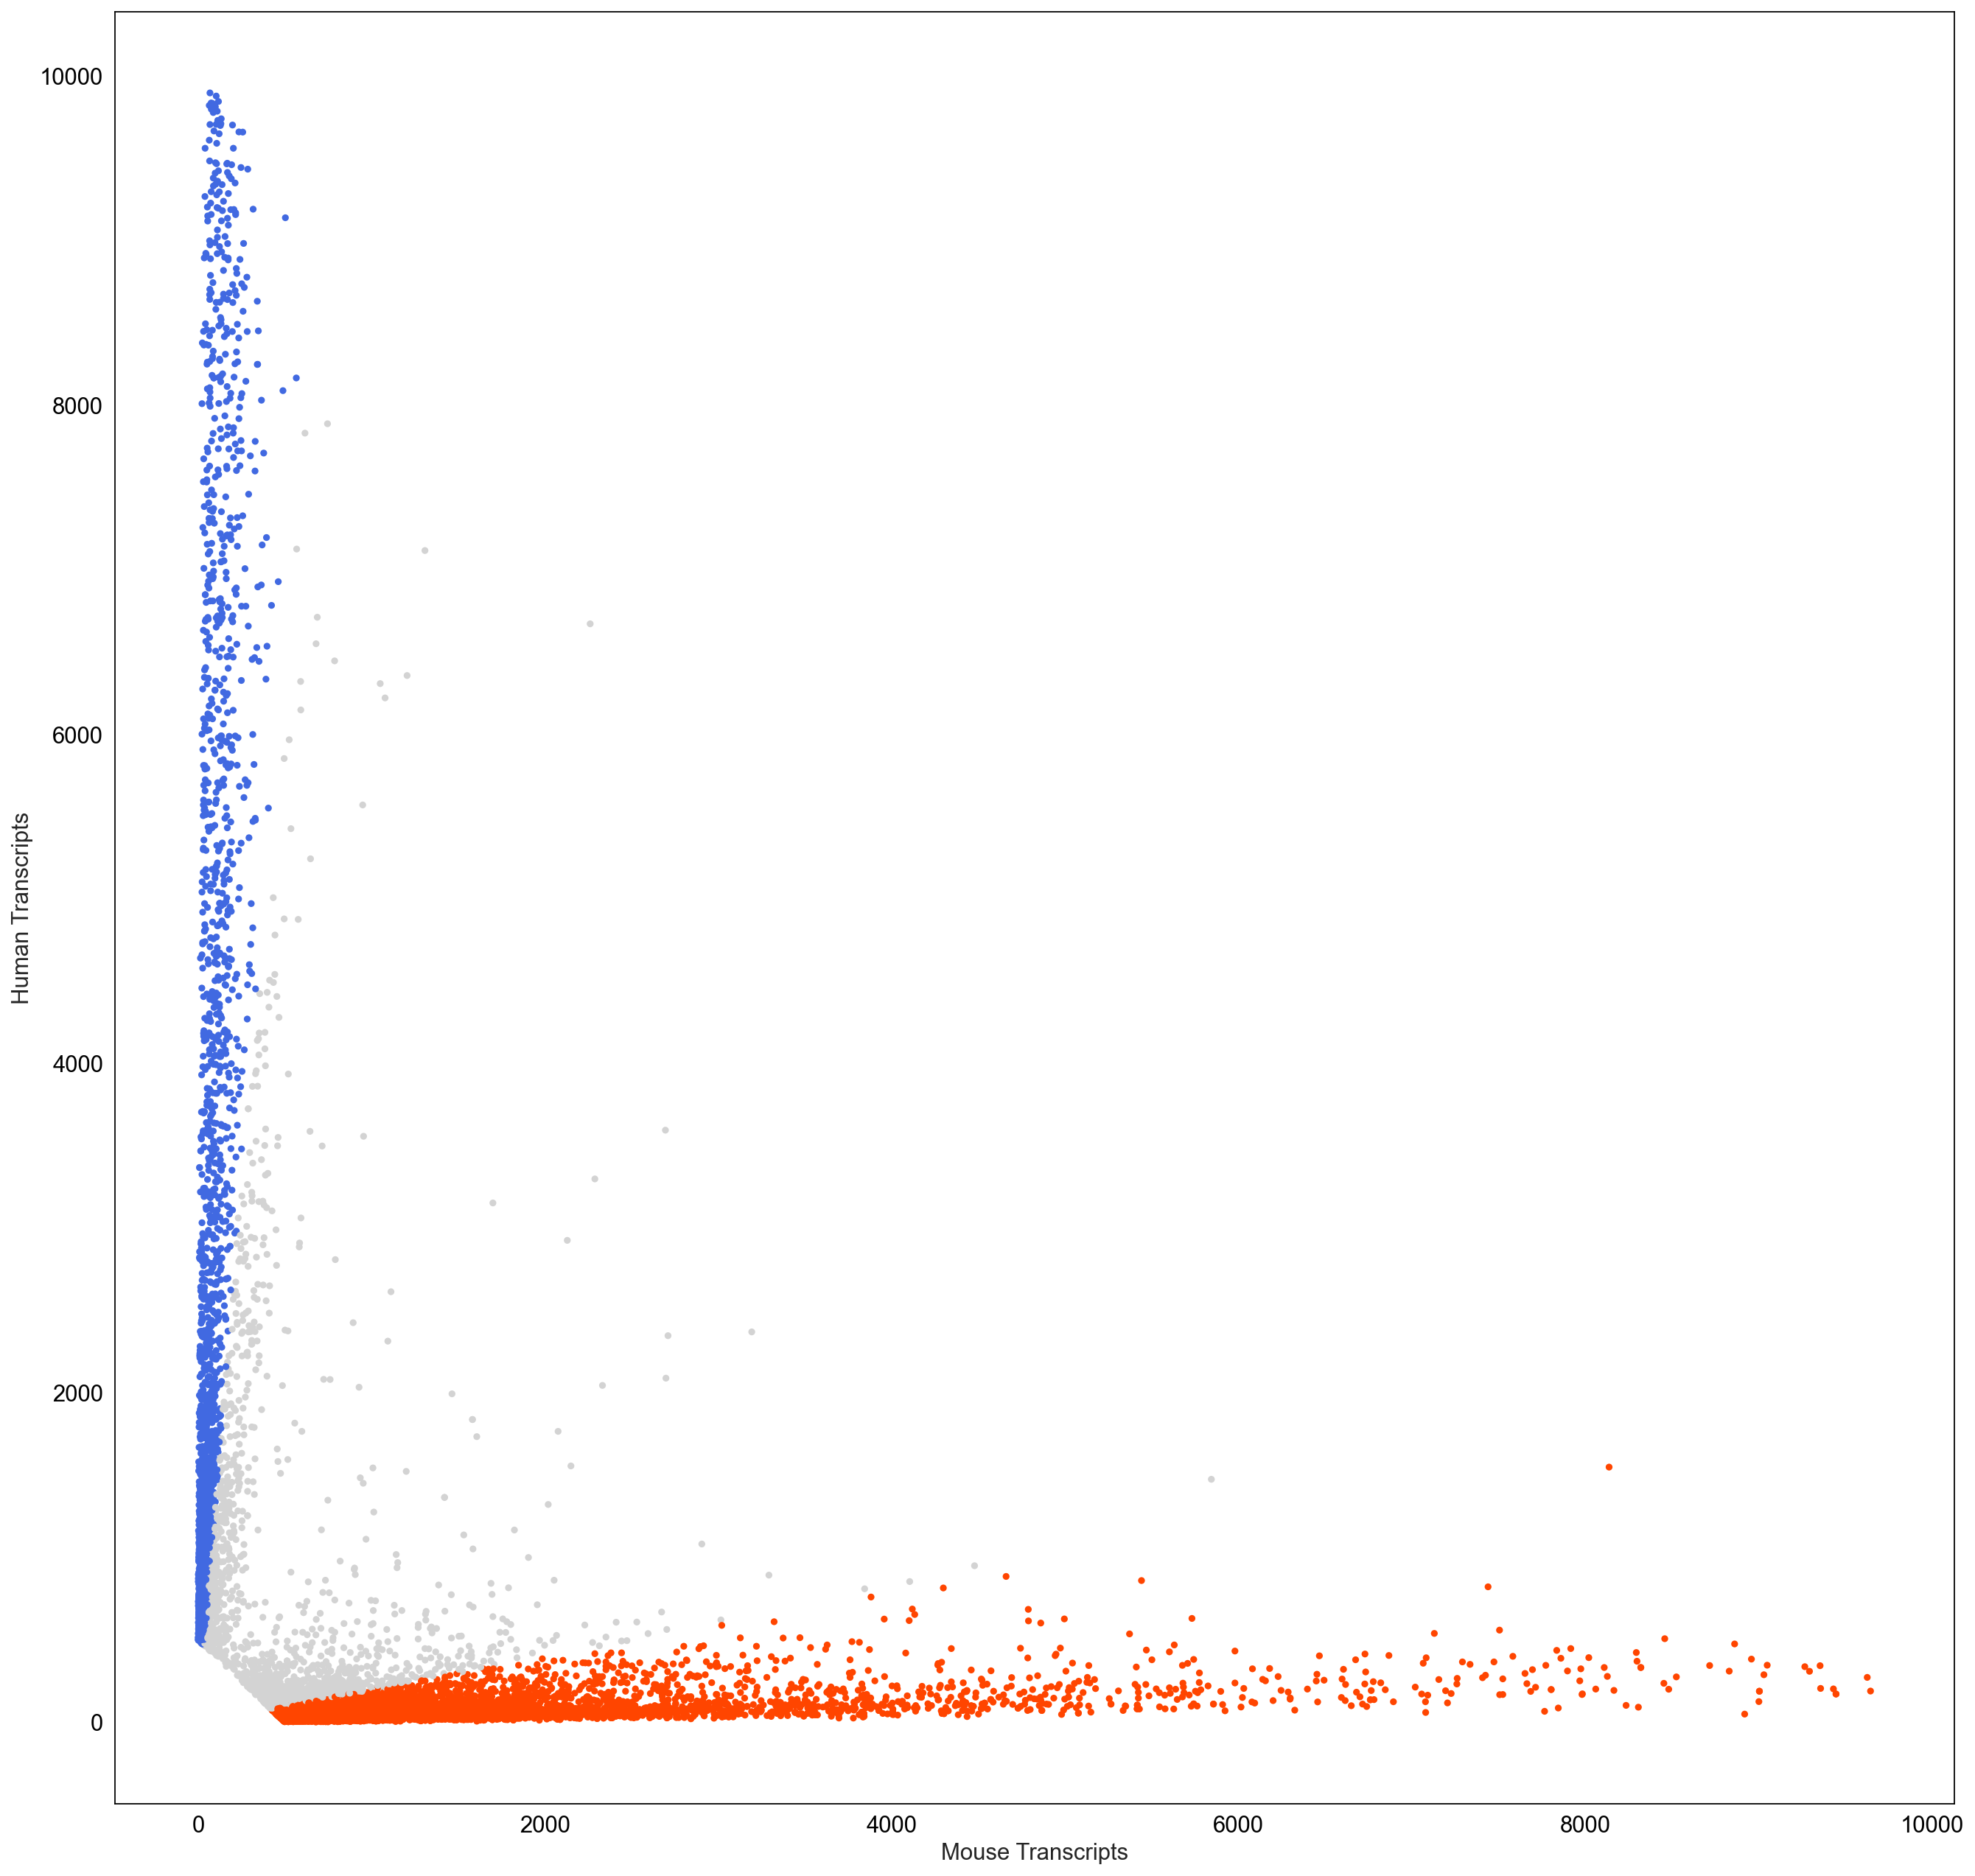

In [132]:
plt.figure(figsize=(20, 20))

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap
           )

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
 

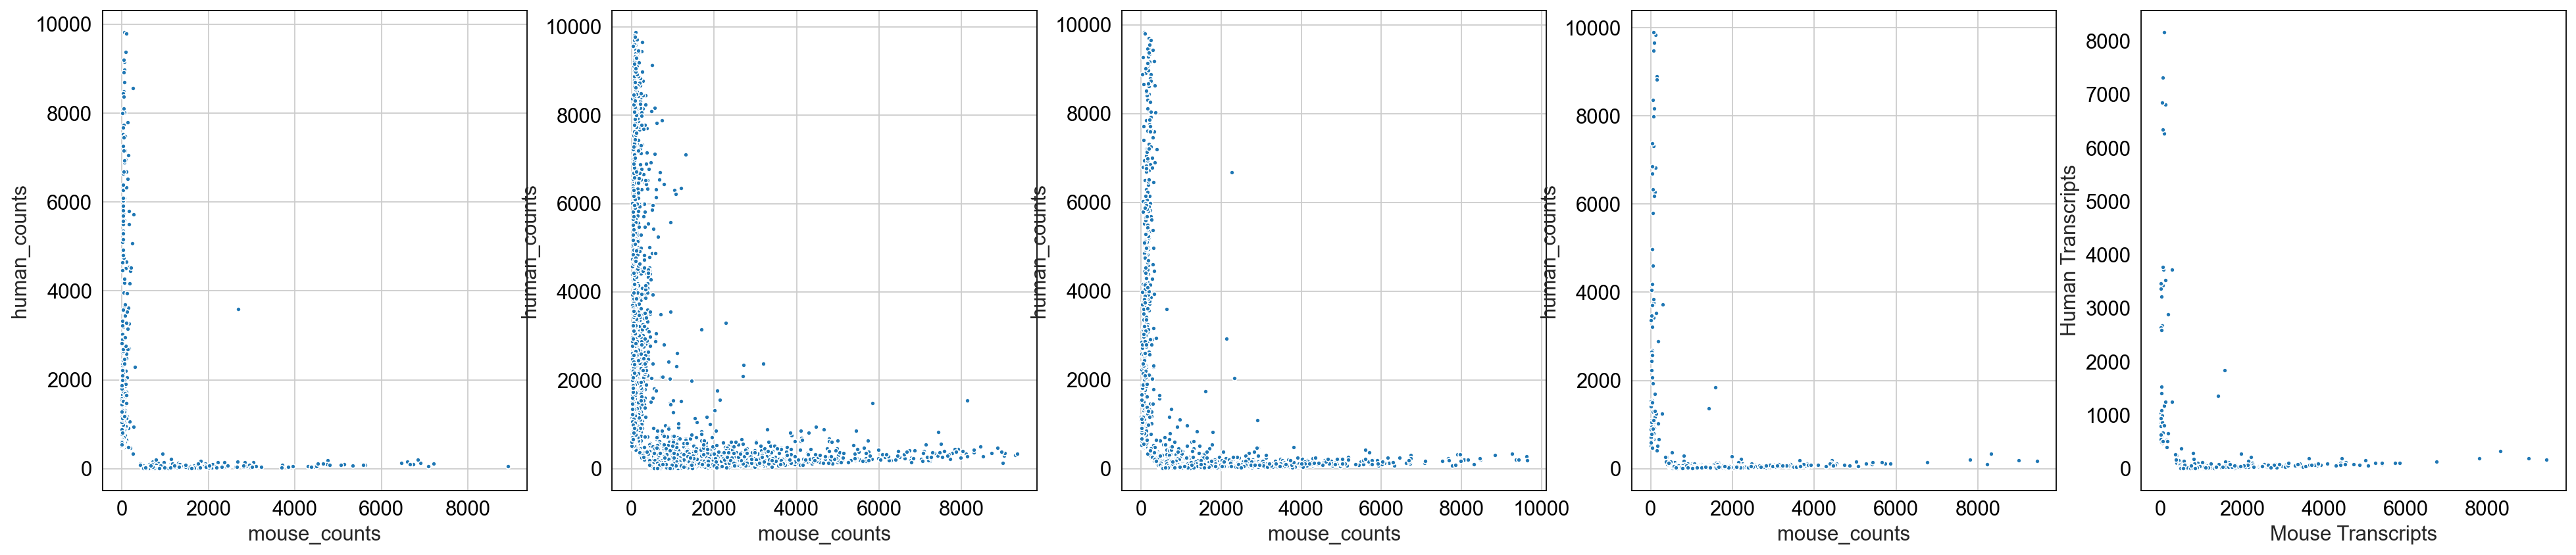

In [133]:
plt.rcParams['figure.figsize'] = 30,6

f, axes = plt.subplots(1, 5)

sns.scatterplot(data=adata[adata.obs.batch == '0'].obs,
               x='mouse_counts',
               y='human_counts',
               s=10,
            #   hue=adata[adata.obs.batch == '0'].obs.cell_call.tolist(),
           ax=axes[0]
           )

sns.scatterplot(data=adata[adata.obs.batch == '1'].obs,
               x='mouse_counts',
               y='human_counts',
               s=10,
           #    hue=adata[adata.obs.batch == '1'].obs.cell_call.tolist(),
           ax=axes[1]
           )

sns.scatterplot(data=adata[adata.obs.batch == '2'].obs,
               x='mouse_counts',
               y='human_counts',
               s=10,
           #    hue=adata[adata.obs.batch == '2'].obs.cell_call.tolist(),
           ax=axes[2]
           )

sns.scatterplot(data=adata[adata.obs.batch == '3'].obs,
               x='mouse_counts',
               y='human_counts',
               s=10,
           #    hue=adata[adata.obs.batch == '3'].obs.cell_call.tolist(),
           ax=axes[3]
           )

sns.scatterplot(data=adata[adata.obs.batch == '4'].obs,
               x='mouse_counts',
               y='human_counts',
               s=10,
           #    hue=adata[adata.obs.batch == '4'].obs.cell_call.tolist(),
           ax=axes[4]
           )


plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

In [134]:
adata.obs['cell_call'].value_counts(normalize=True)

M    0.638813
H    0.257685
C    0.103502
Name: cell_call, dtype: float64

In [135]:
2*0.103502

0.207004

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


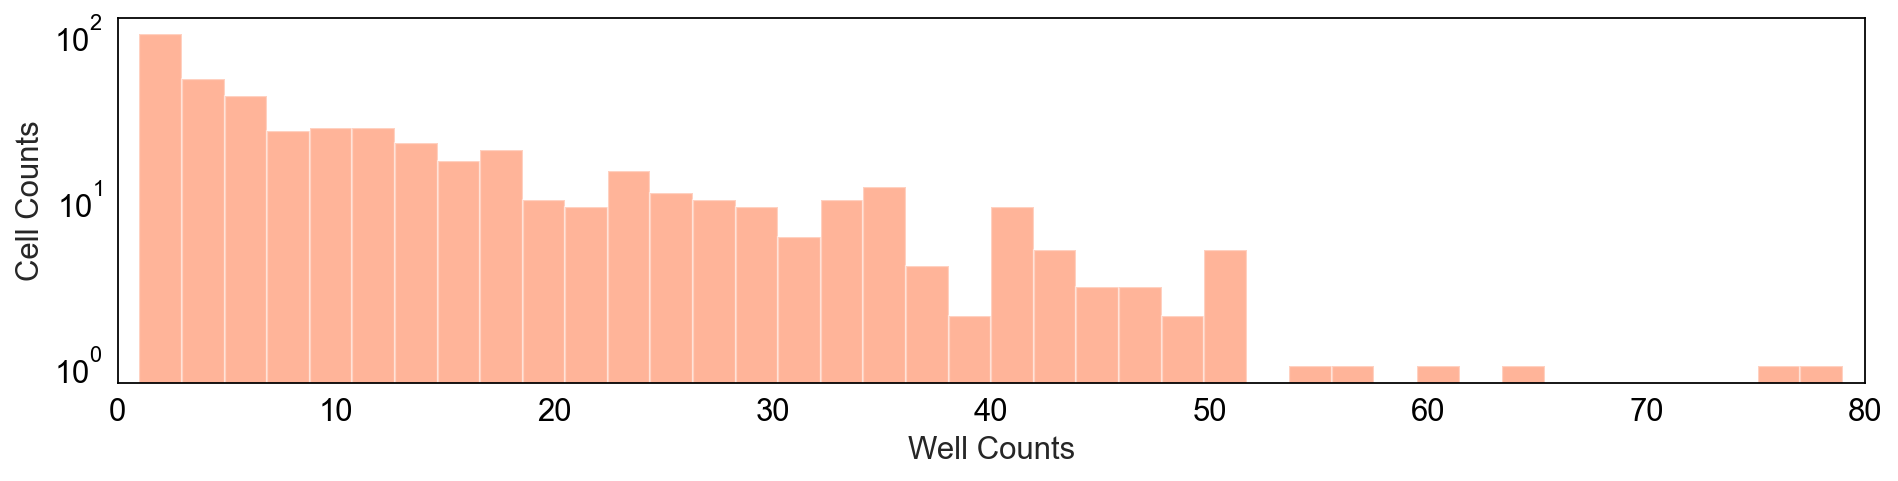

In [136]:
##plot cells per well
well_counts_M = adata[adata.obs.cell_call == 'M'].obs.groupby('barcode').size()

plt.rcParams['figure.figsize'] = [14, 3]

g = sns.distplot(well_counts_M,
             kde=False,
             bins=40,
             color='orangered'
            )

g.set_yscale('log')
g.set_xlim(0,80)

g.set_ylabel('Cell Counts')
g.set_xlabel('Well Counts')

plt.grid(False)

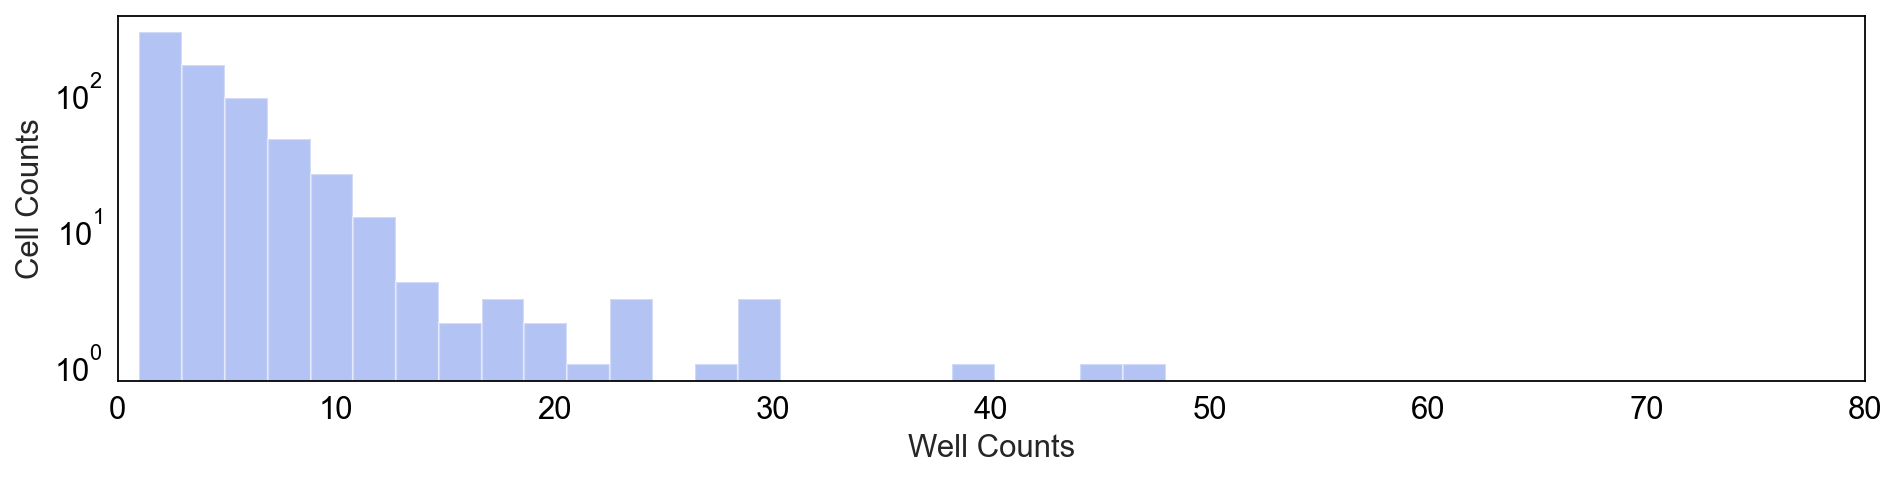

In [137]:
well_counts_H = adata[adata.obs.cell_call == 'H'].obs.groupby('barcode').size()


g = sns.distplot(well_counts_H,
             kde=False,
             bins=24,
             color='royalblue'
            )


g.set_yscale('log')
g.set_xlim(0,80)

g.set_ylabel('Cell Counts')
g.set_xlabel('Well Counts')

plt.grid(False)

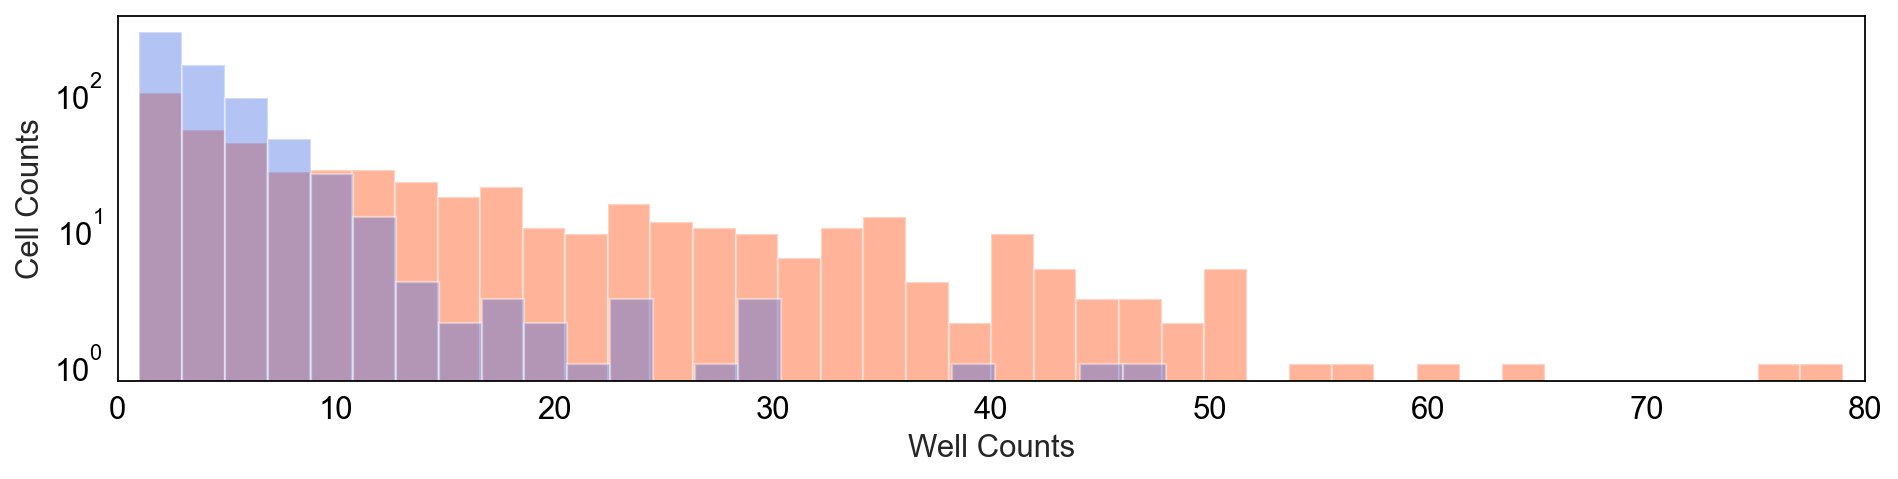

In [138]:
##plot cells per well
well_counts_M = adata[adata.obs.cell_call == 'M'].obs.groupby('barcode').size()

plt.rcParams['figure.figsize'] = [14, 3]

g = sns.distplot(well_counts_M,
             kde=False,
             bins=40,
             color='orangered'
            )

well_counts_H = adata[adata.obs.cell_call == 'H'].obs.groupby('barcode').size()


g = sns.distplot(well_counts_H,
             kde=False,
             bins=24,
             color='royalblue'
            )


g.set_yscale('log')
g.set_xlim(0,80)

g.set_ylabel('Cell Counts')
g.set_xlabel('Well Counts')

plt.grid(False)

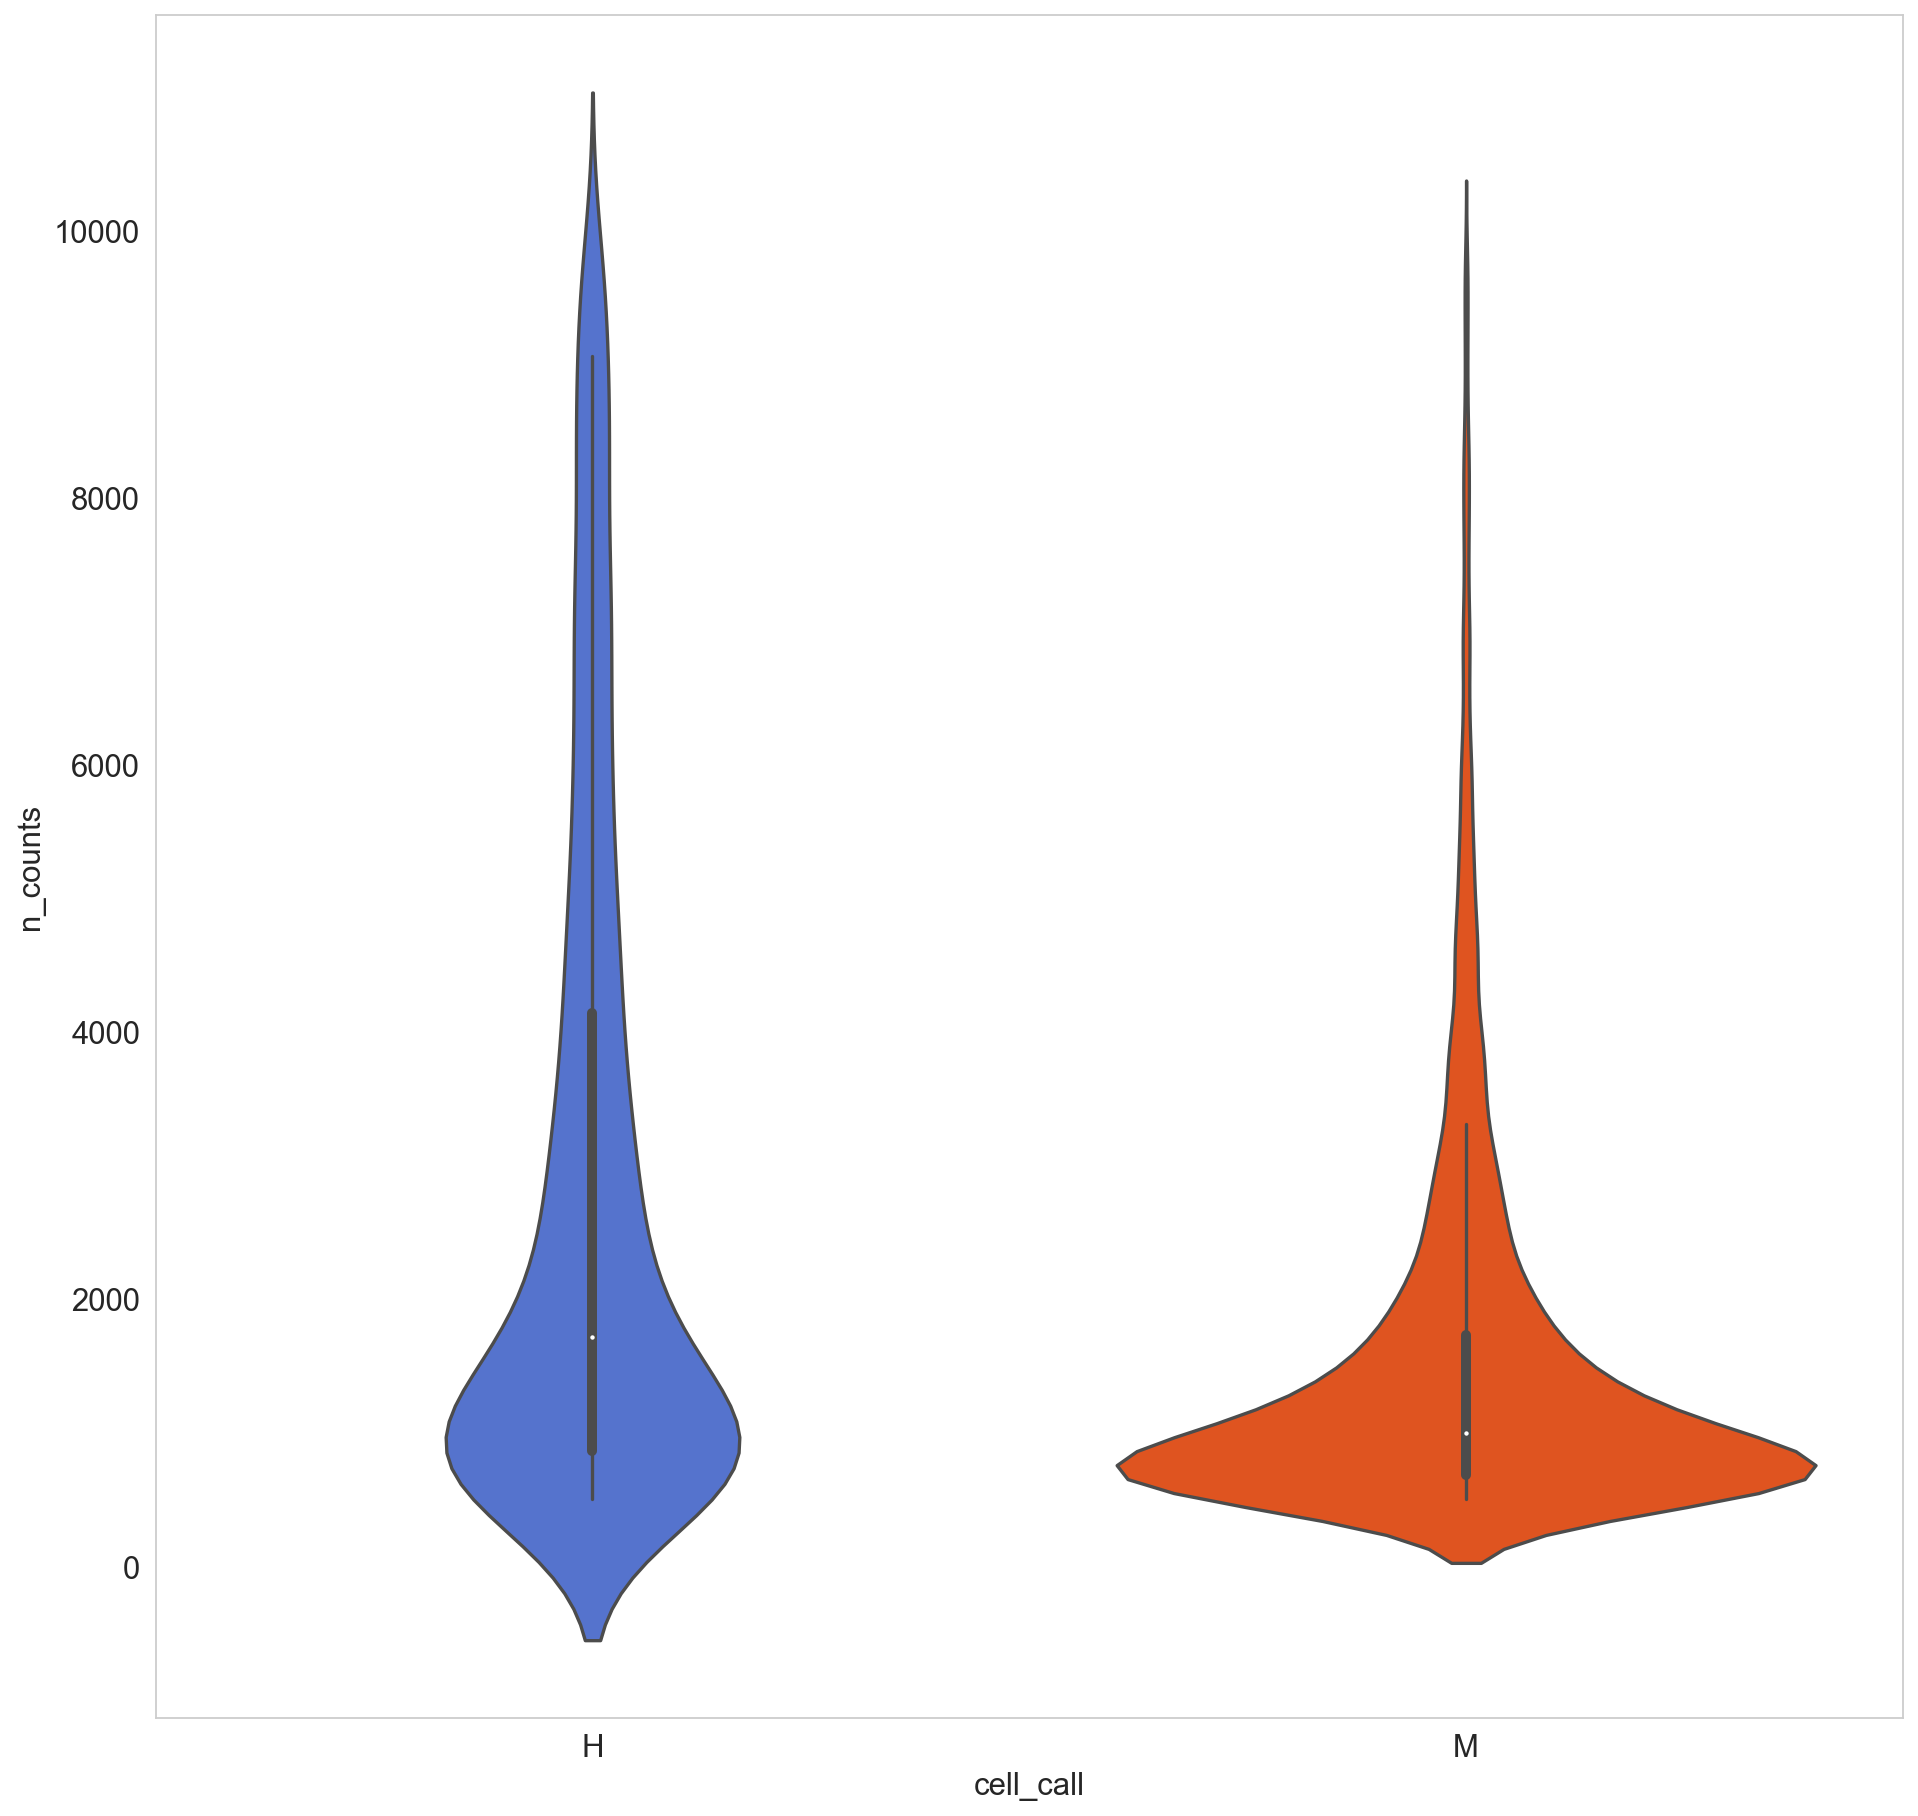

In [167]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered'],
               
              );

#plt.axis('off')
plt.grid(False)

In [140]:
print("median UMIs mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_counts)))

print("median UMIs human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_counts)))



median UMIs mouse: 999.0
median UMIs human: 1715.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


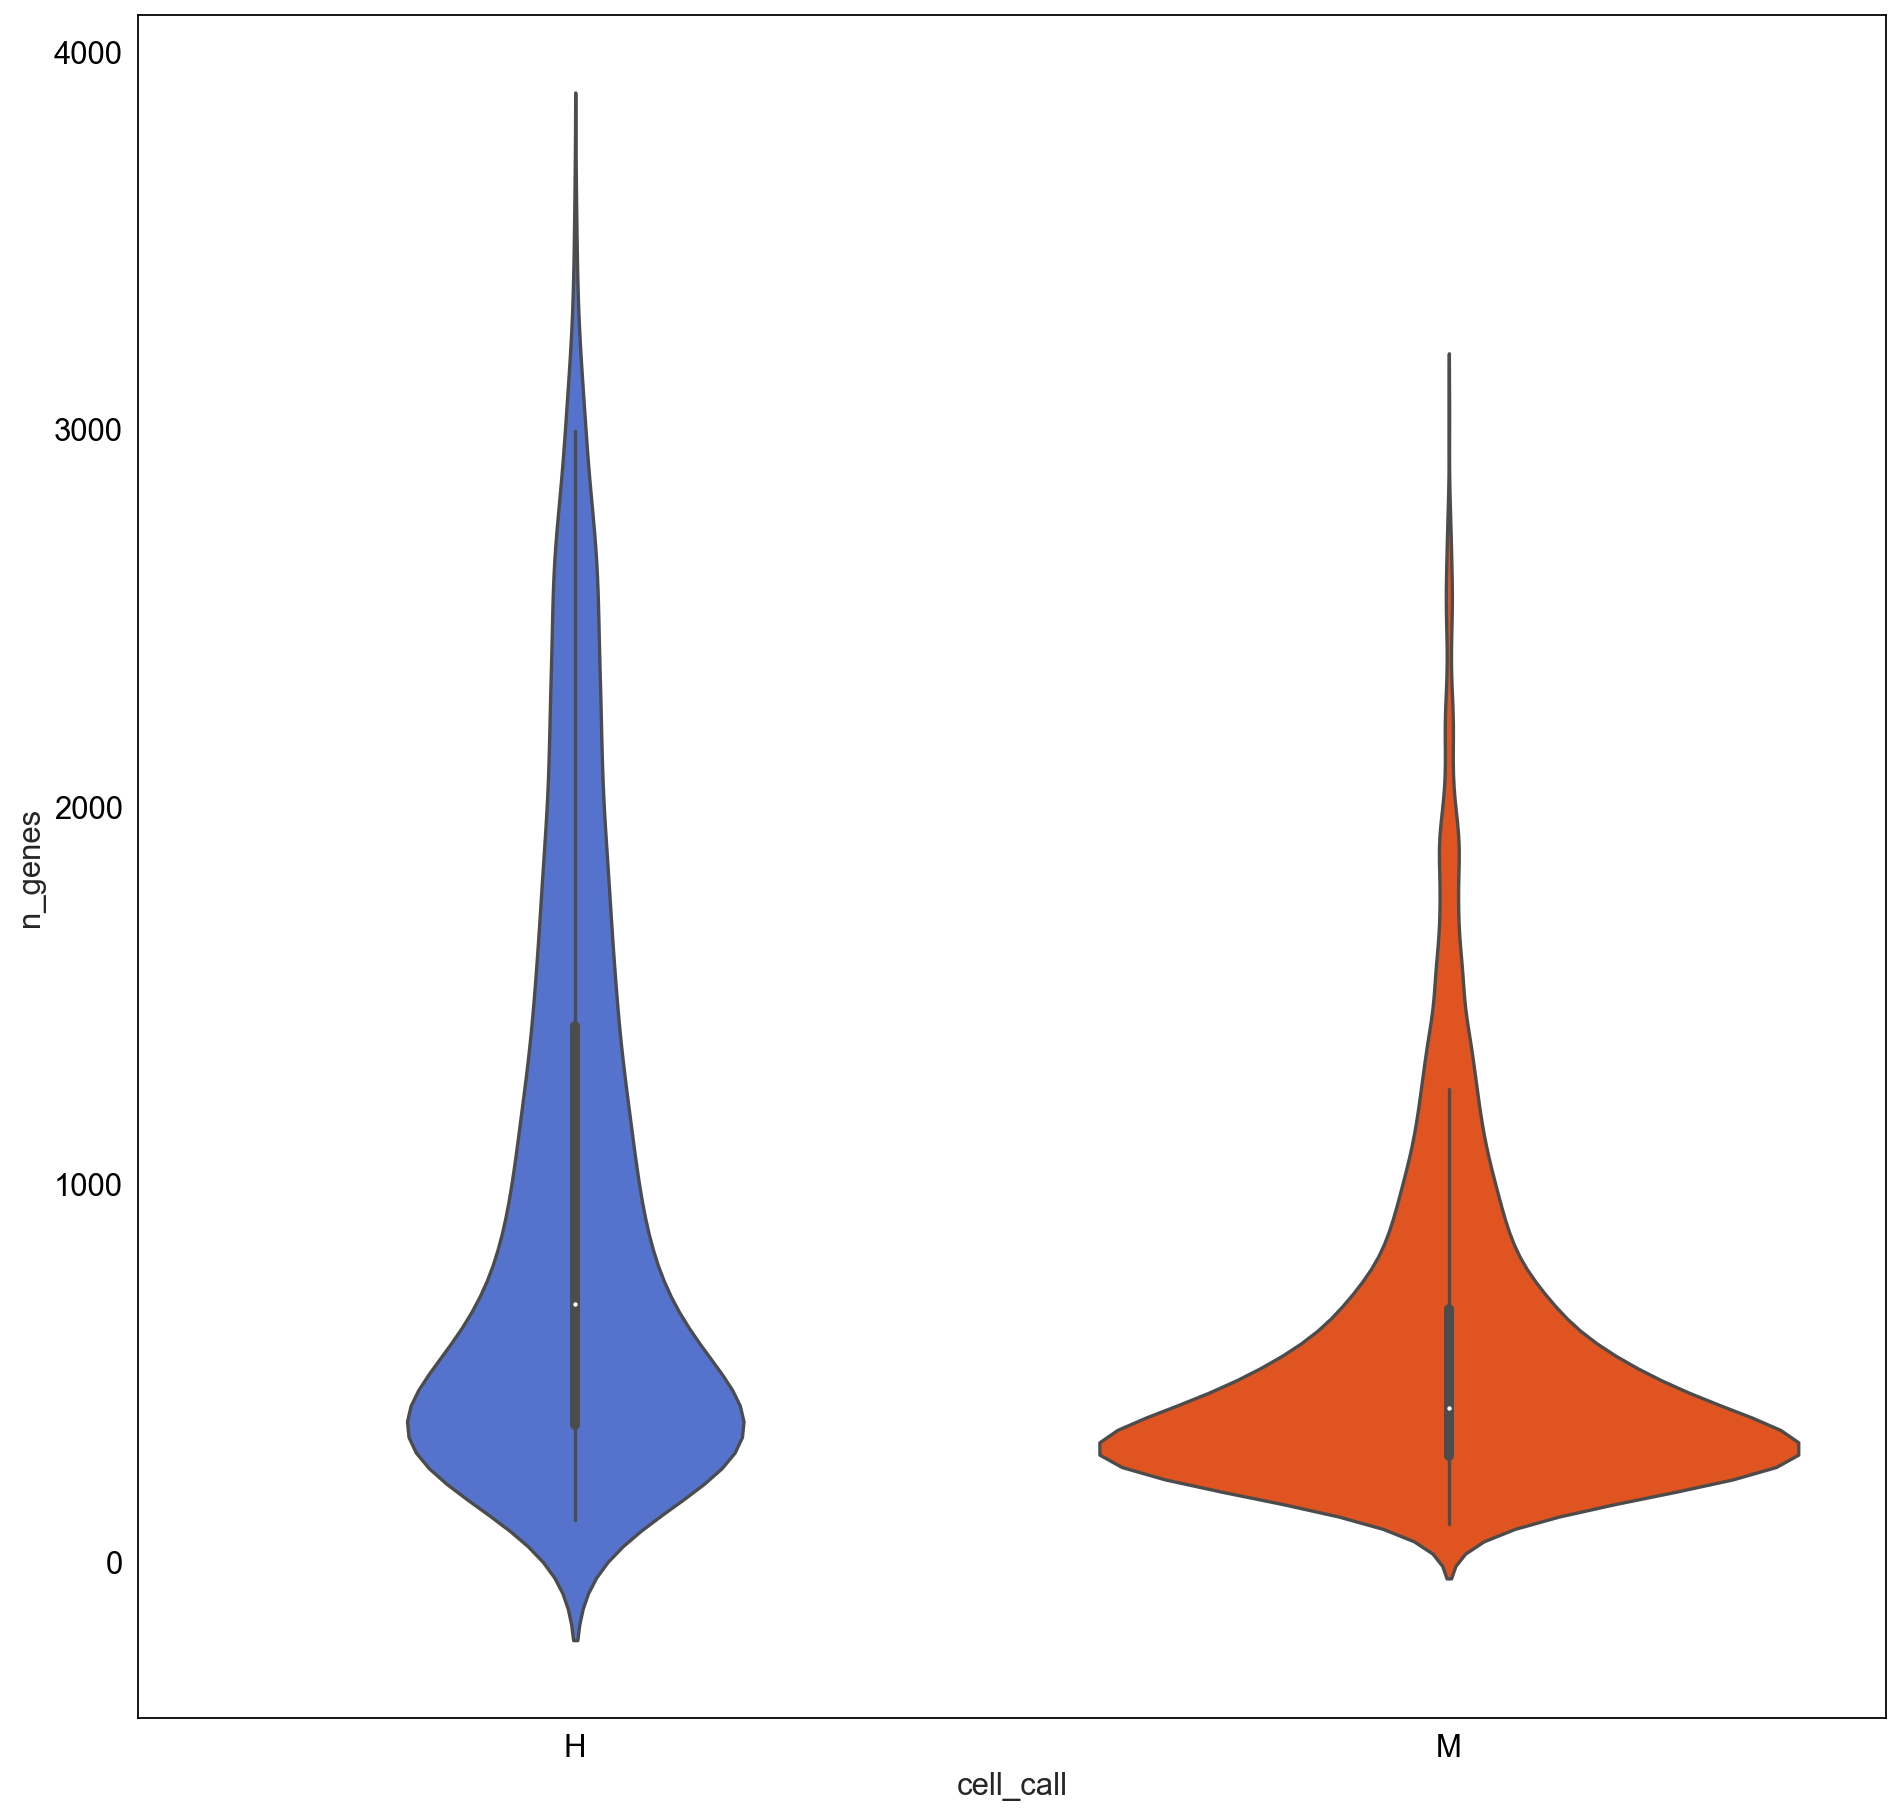

In [141]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

#plt.axis('off')
plt.grid(False) 

In [142]:
print("median genes mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)))

print("median genes human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_genes)))




median genes mouse: 407.0
median genes human: 683.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [143]:
sns.set_style("whitegrid", {'axes.grid' : False})

plate_map='~/projects/XYZeq/data/20181219_species_exp/plate23_map.csv'
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])

spatial_map['Y'] = -spatial_map['Y']

tmp=[]

for index, row in spatial_map.iterrows():
    if row['X']%2==0:
        m=row['Y'] - .5
        tmp.append(m)
    else:
        tmp.append(row['Y'])
        
spatial_map['Y_offset'] = pd.DataFrame(tmp)

spatial_map = spatial_map.drop(['Y'],axis=1)

spatial_map.columns = ['barcode','X','Y']



In [144]:
adata.obs = adata.obs.reset_index().merge(spatial_map, on='barcode',how='left').set_index('index')

In [145]:
adata_batch_1 = adata[adata.obs.batch == '1']

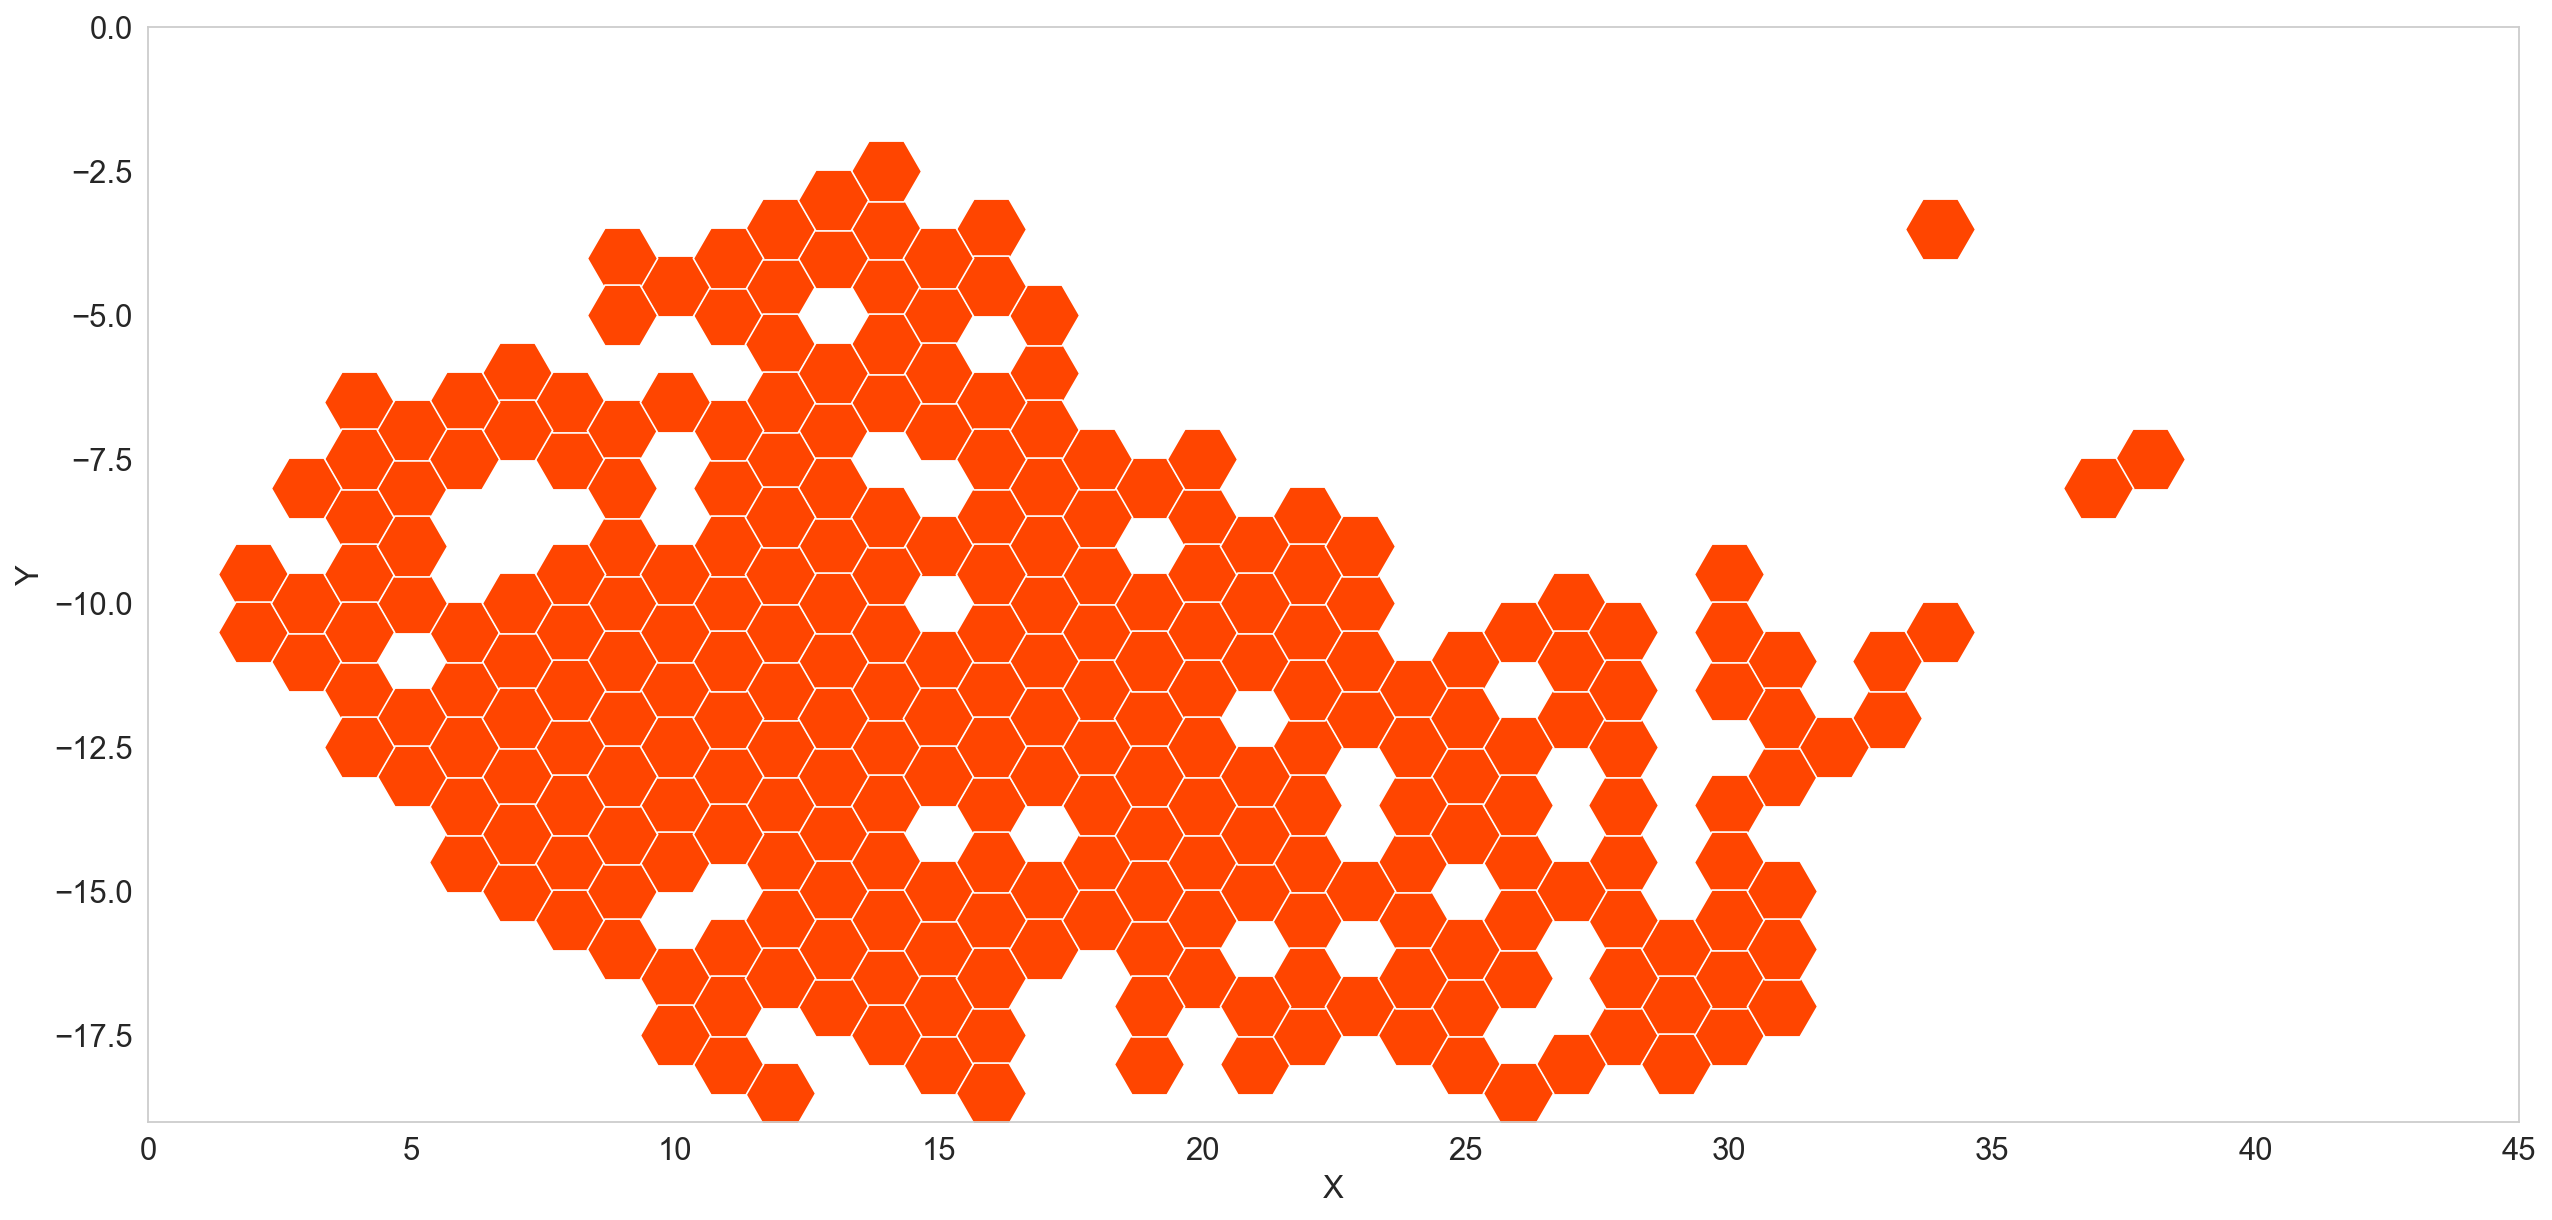

In [146]:
plt.rcParams['figure.figsize'] = [19, 9]


sns.set_style("whitegrid", {'axes.grid' : False})


plt.xlim(0, 45)
plt.ylim(-19,0)

g = sns.scatterplot(data=adata_batch_1[adata_batch_1.obs.cell_call == 'M'].obs.groupby('barcode').median(),
                x='X',
                y='Y',  
                marker="H",
#                hue='ratio',
                s=1000,
                c=['orangered']

               )

#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


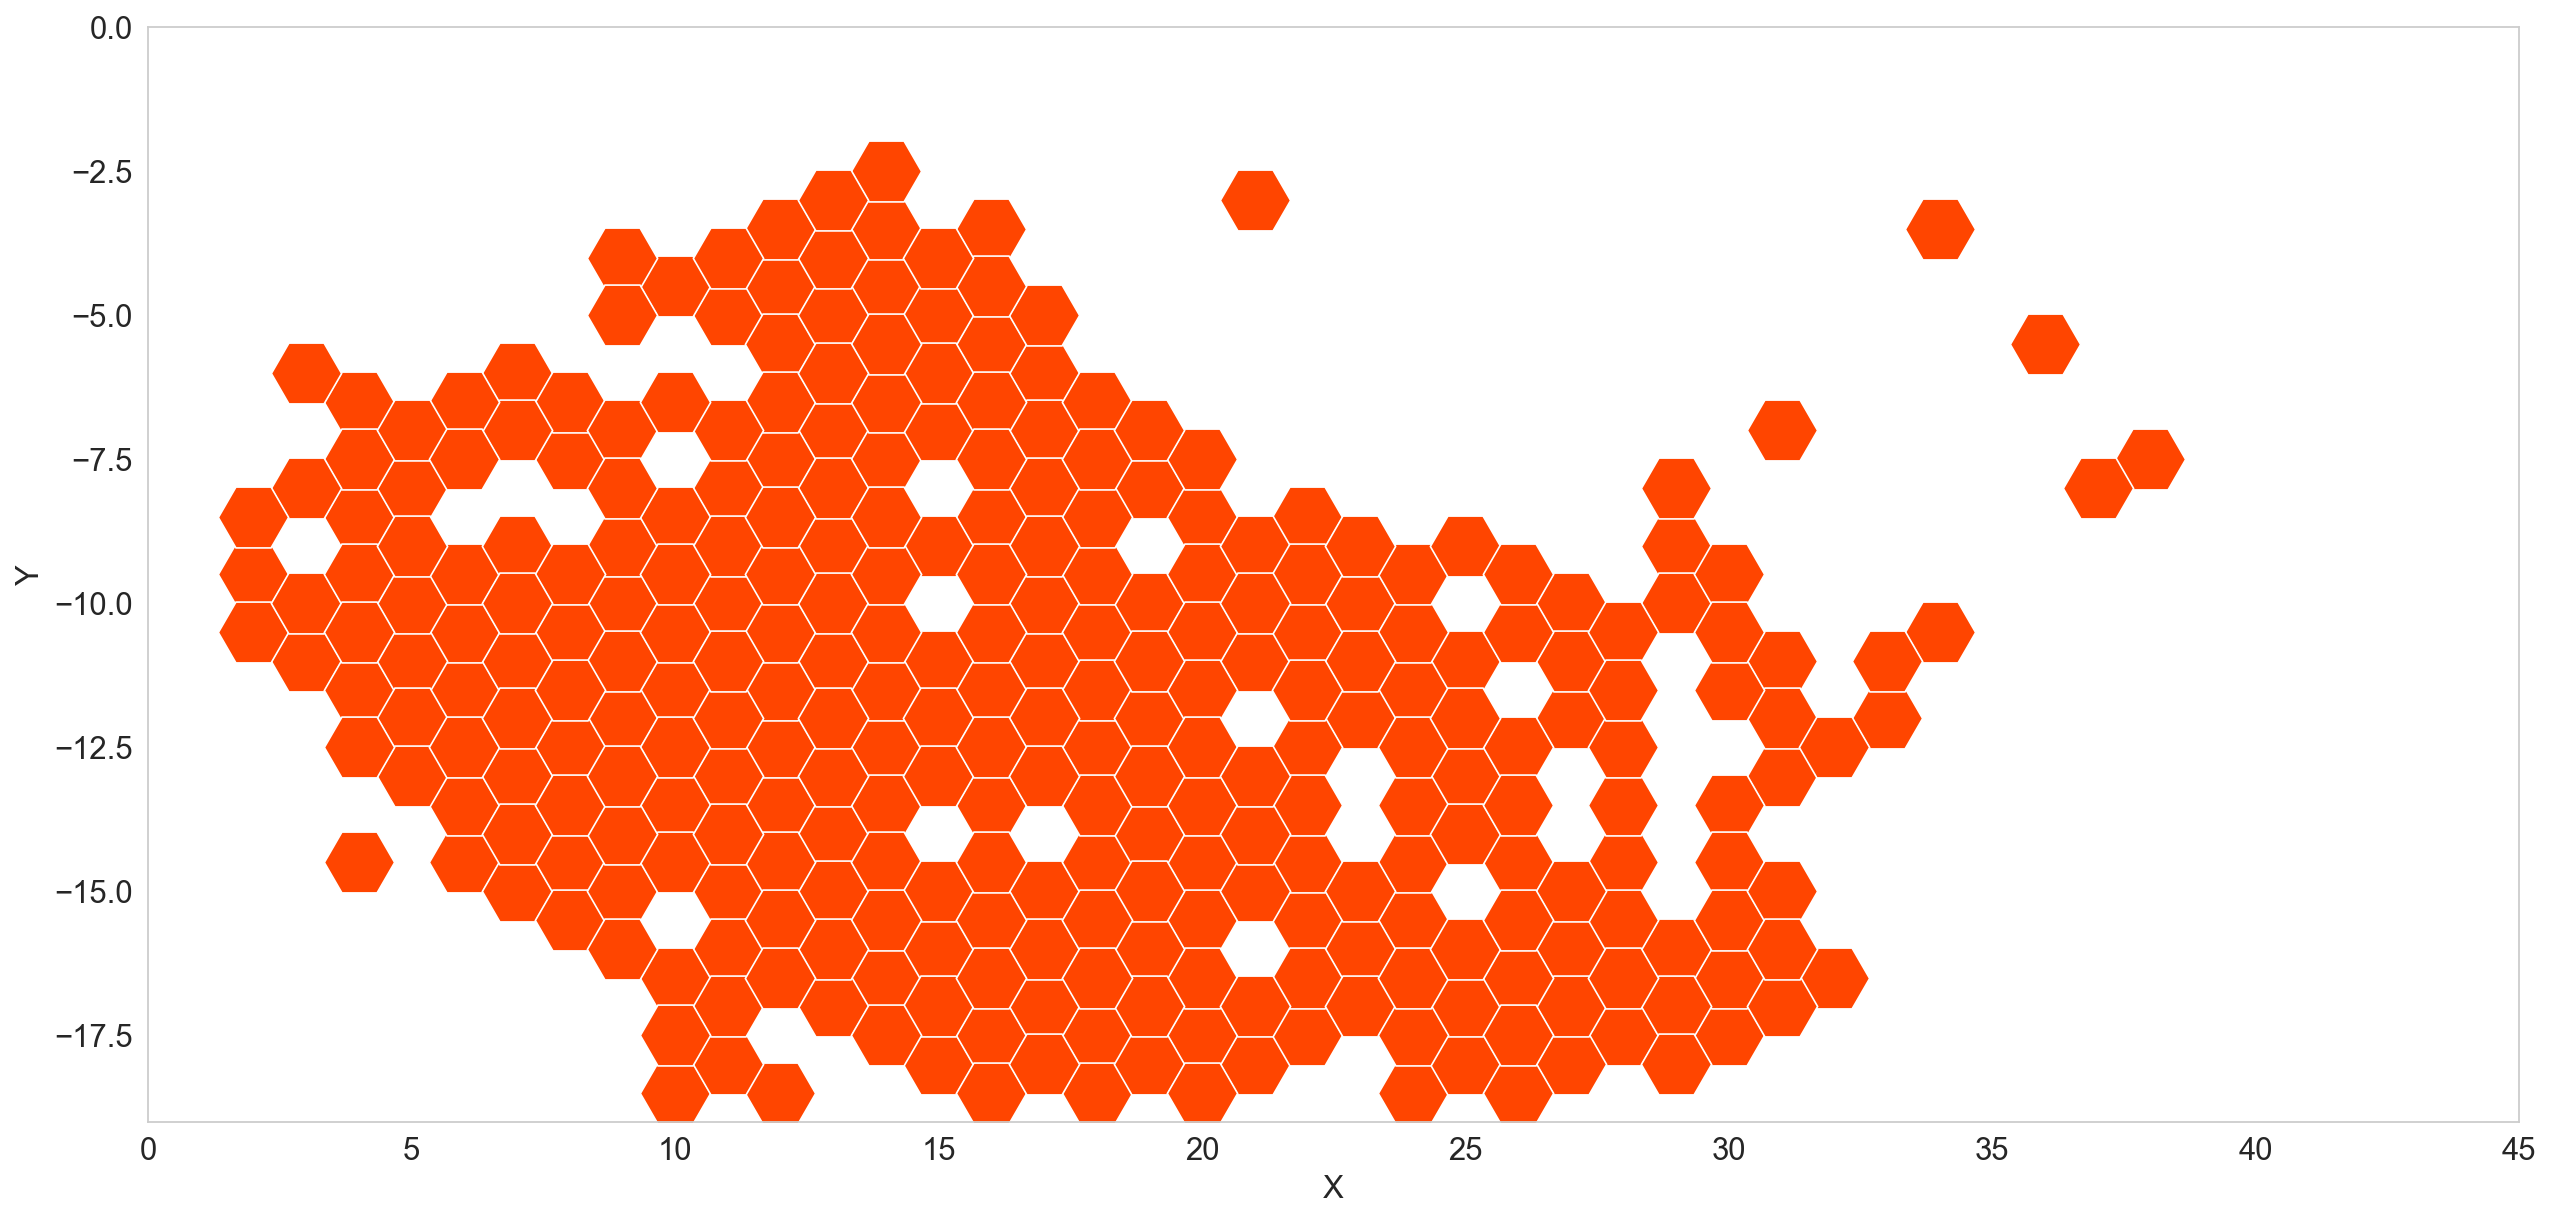

In [147]:
## Including collision cells 

plt.rcParams['figure.figsize'] = [19, 9]


sns.set_style("whitegrid", {'axes.grid' : False})


plt.xlim(0, 45)
plt.ylim(-19,0)

g = sns.scatterplot(data=adata_batch_1[adata_batch_1.obs.cell_call != 'H'].obs.groupby('barcode').median(),
                x='X',
                y='Y',  
                marker="H",
#                hue='ratio',
                s=1000,
                c=['orangered']

               )

#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


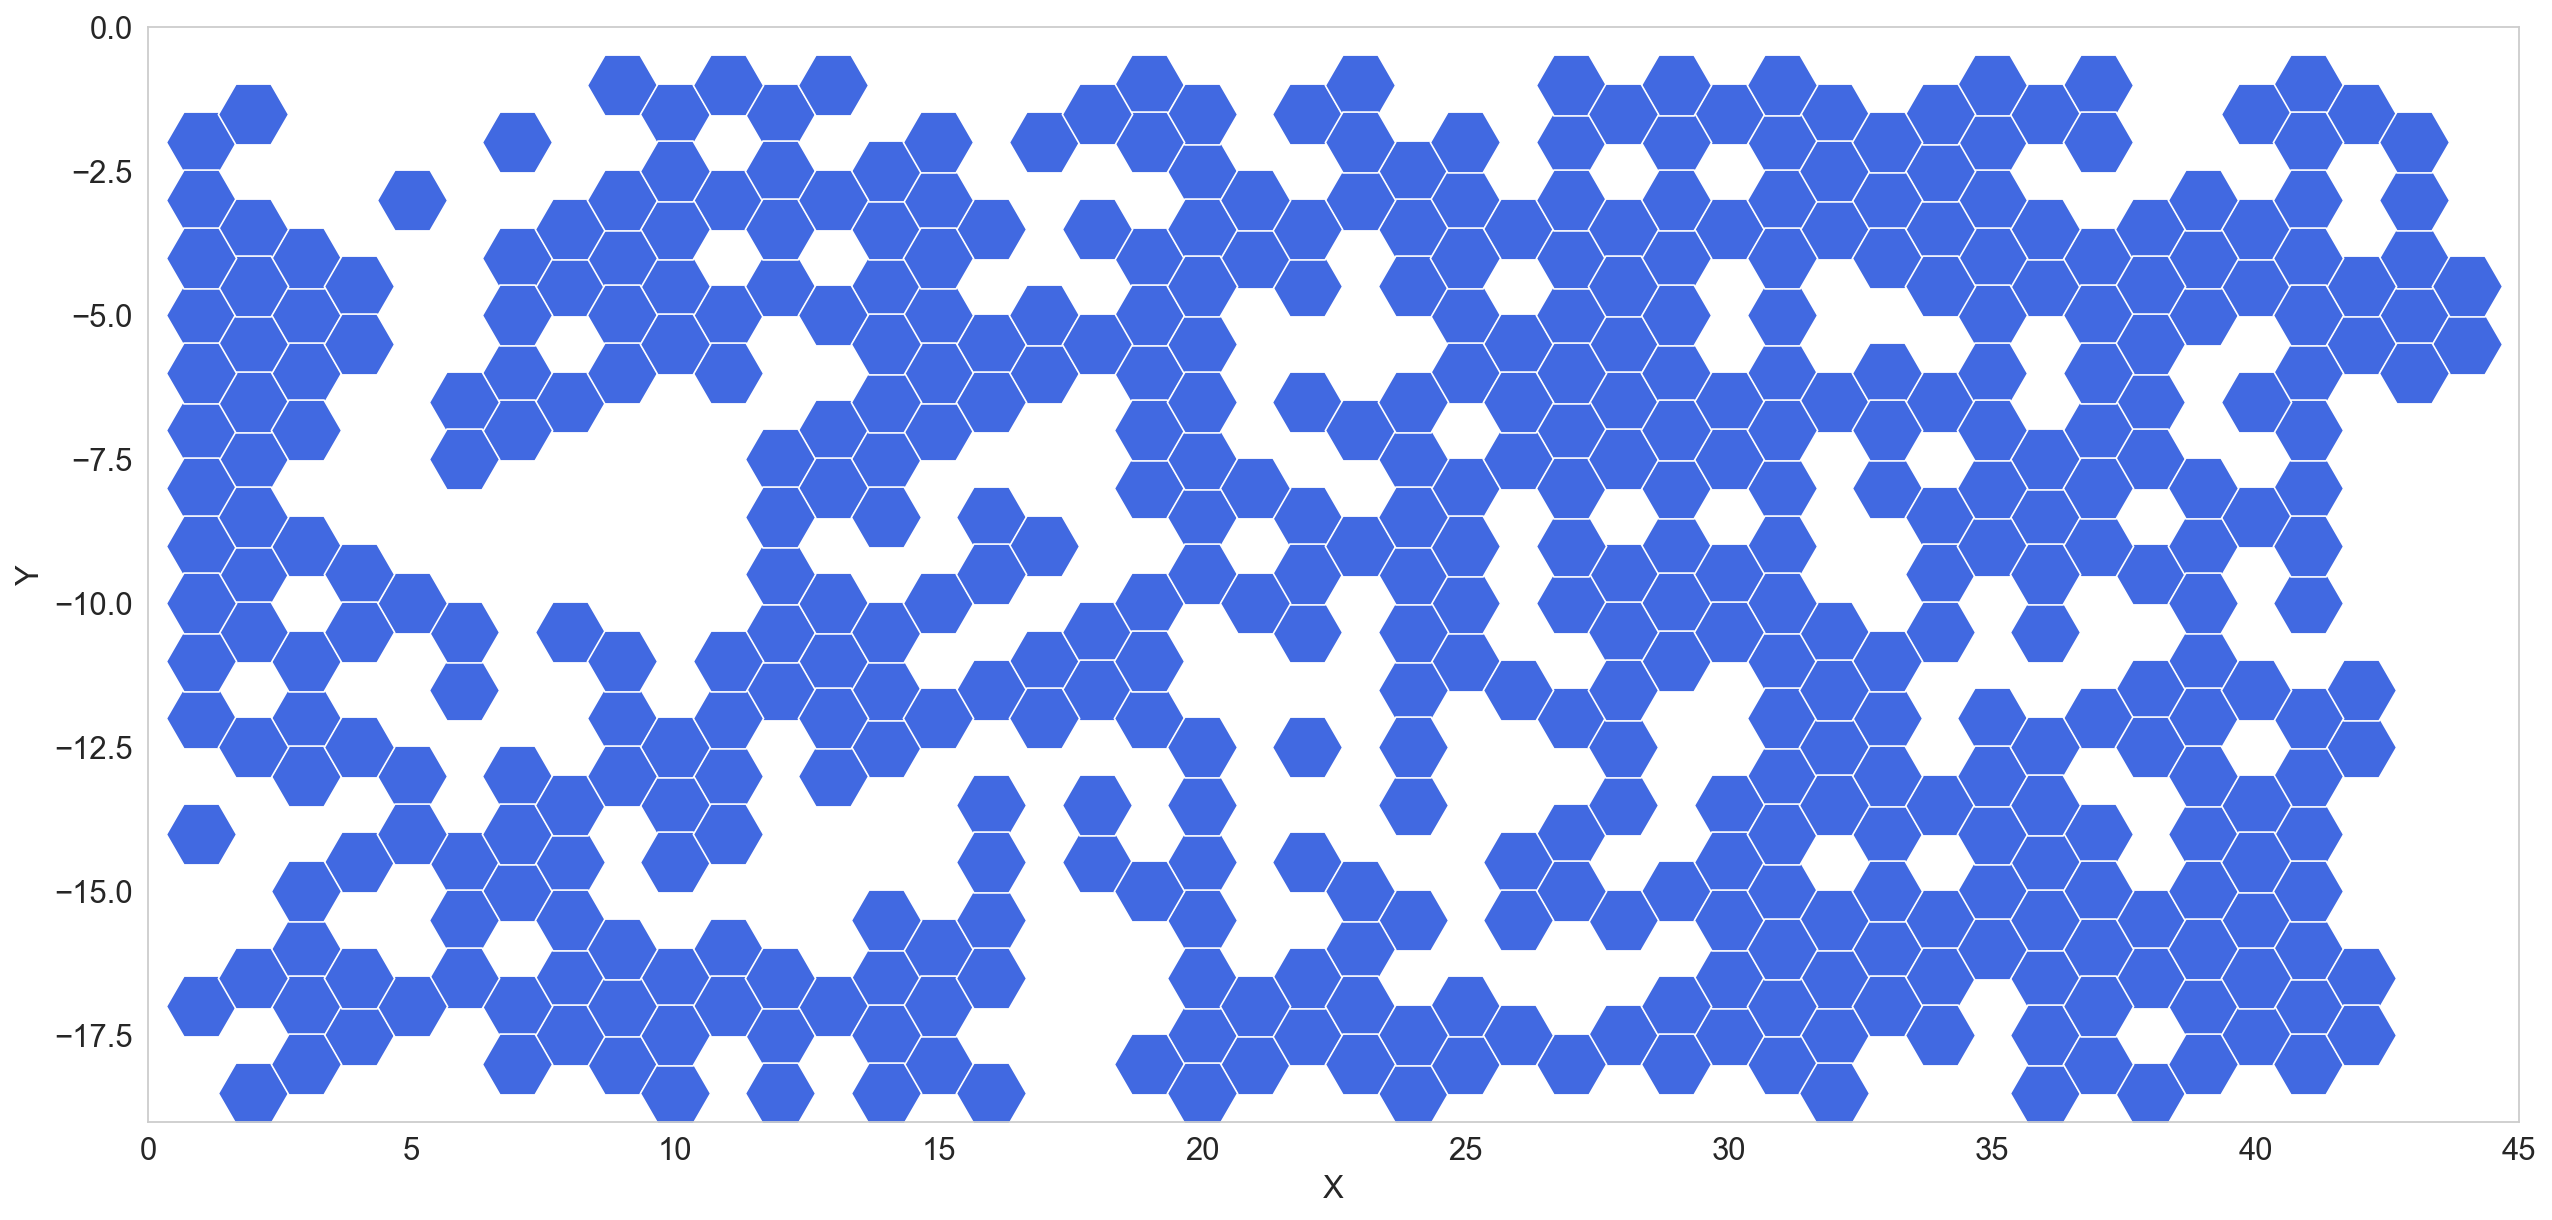

In [148]:
plt.rcParams['figure.figsize'] = [19, 9]


sns.set_style("whitegrid", {'axes.grid' : False})


plt.xlim(0, 45)
plt.ylim(-19,0)

g = sns.scatterplot(data=adata_batch_1[adata_batch_1.obs.cell_call == 'H'].obs.groupby('barcode').median(),
                x='X',
                y='Y',  
                marker="H",
#                hue='ratio',
                s=1000,
                c=['royalblue']

               )

#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

# Decontaminated Data

In [149]:
adata_decontam = sc.read_csv('../../../../decont_mat/decont_mat_after_v2.csv').T


In [150]:
# Quality control - calculate QC covariates
adata_decontam.obs['n_counts'] = adata_decontam.X.sum(1)

adata_decontam.obs['log_counts'] = np.log(adata_decontam.obs['n_counts'])

adata_decontam.obs['n_genes'] = (adata_decontam.X > 0).sum(1)

In [151]:
adata_decontam.obs['barcode'] = adata_decontam.obs.index.str[-18:-2]

adata_decontam.obs['batch'] = adata_decontam.obs.index.str[-1:]

In [152]:
adata_decontam.var_names_make_unique()

In [153]:
mito_genes_mouse=[name for name in adata_decontam.var_names if name.startswith(('mm10_mt-'))]
                                                              
#mito_genes_human=[name for name in adata.var_names if name.startswith(('hg19_MT-'))] 

adata_decontam.obs['percent_mito_mouse'] = np.sum(adata_decontam[:, mito_genes_mouse].X, axis=1) / np.sum(adata_decontam.X, axis=1)*100

#adata.obs['percent_mito_human'] = np.sum(adata[:, mito_genes_human].X, axis=1) / np.sum(adata.X, axis=1)*100

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [154]:
sc.pp.filter_cells(adata_decontam, min_counts = 500)
sc.pp.filter_cells(adata_decontam, min_genes = 100)
sc.pp.filter_genes(adata_decontam, min_cells=1)
adata_decontam = adata_decontam[adata_decontam.obs['n_counts'] < 10000, :]

adata_decontam = adata_decontam[adata_decontam.obs['percent_mito_mouse'] < 1, :]

filtered out 1522 cells that have less than 500 counts
filtered out 5 cells that have less than 100 genes expressed
filtered out 3873 genes that are detected in less than 1 cells


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [155]:
adata_decontam.obs.batch.value_counts()

1    4064
2    2371
3    1040
0     767
4     505
Name: batch, dtype: int64

In [156]:
#barnyard

mouse_genes=[name for name in adata_decontam.var_names if name.startswith('mm10_')]

#mouse_genes=[name for name in adata.var_names if name.startswith('mm10___')]
#human_genes=[name for name in adata.var_names if name.startswith('GRCh38_')]

human_genes=[name for name in adata_decontam.var_names if name.startswith('hg19_')]


adata_decontam.obs['mouse_counts'] = np.sum(adata_decontam[:, mouse_genes].X, axis=1)
adata_decontam.obs['human_counts'] = np.sum(adata_decontam[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [157]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

np.seterr(divide = 'ignore') 
adata_decontam.obs['ratio'] = np.log10(np.true_divide(adata_decontam.obs['mouse_counts'], adata_decontam.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.66:
                return 'M'
        elif counts['ratio'] < -0.66:
                return 'H'
        else:
                return 'C'

         
adata_decontam.obs['cell_call']=adata_decontam.obs.apply(lambda counts: cell_call(counts), axis=1)



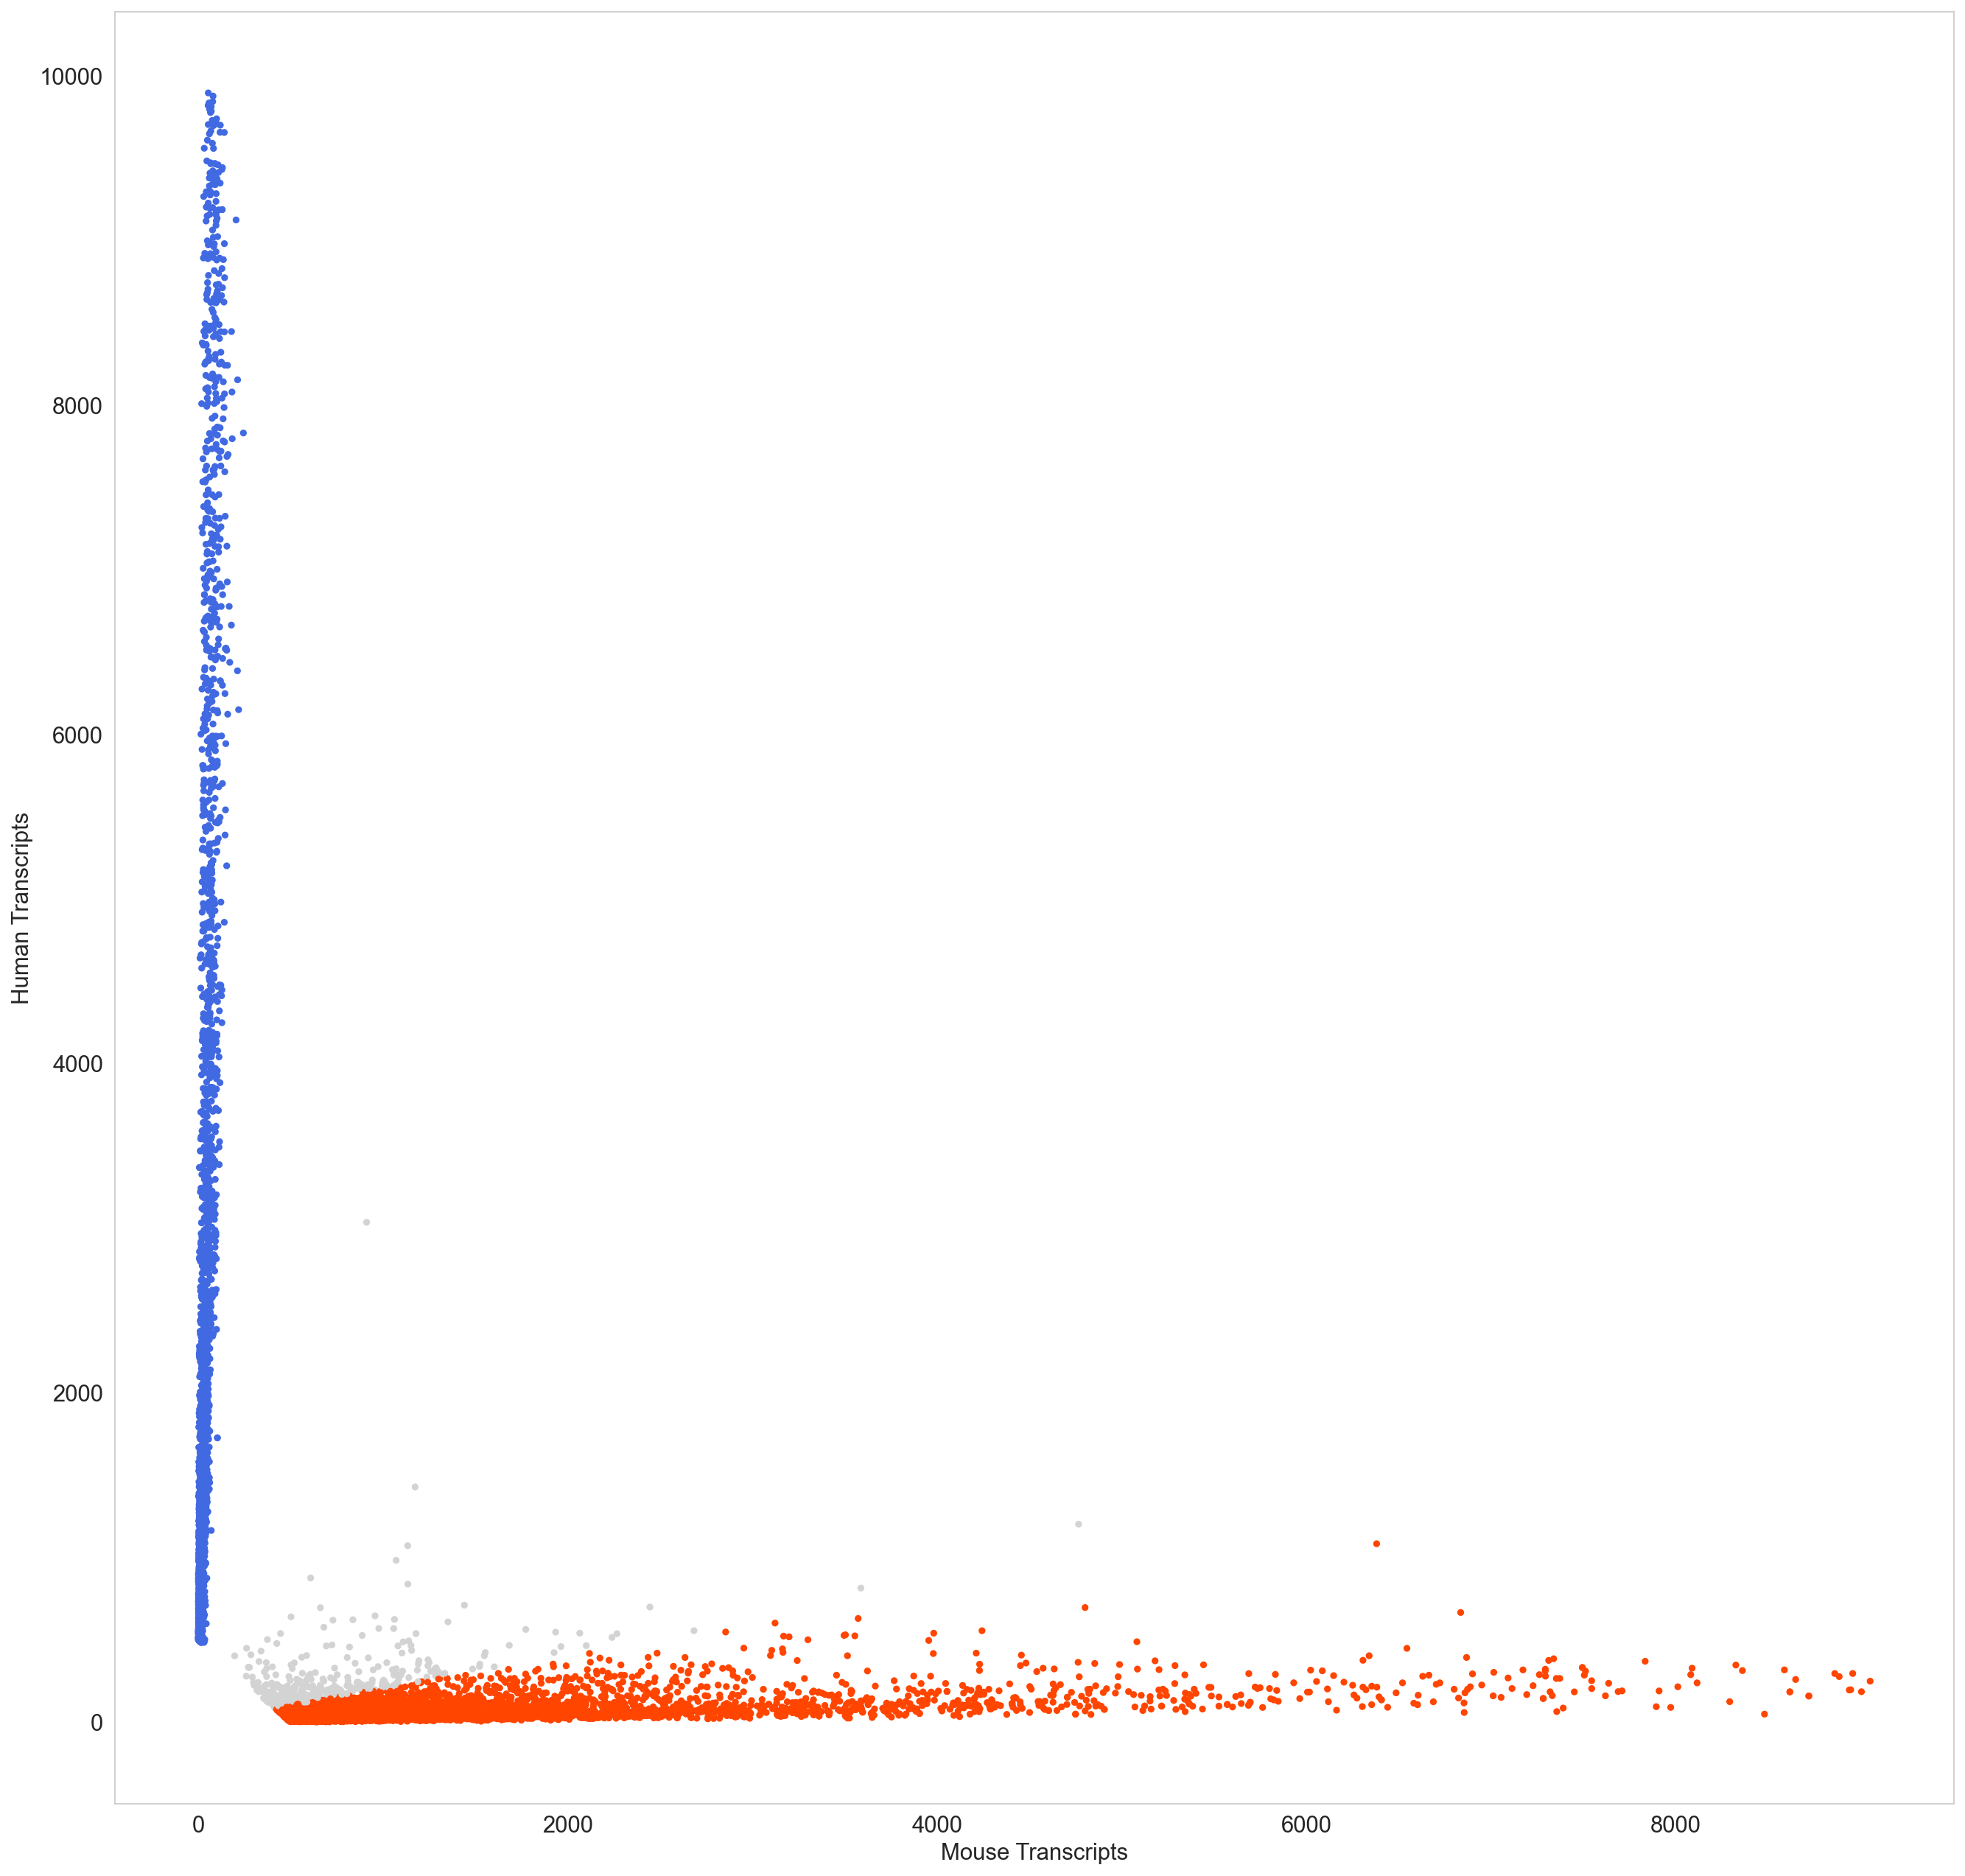

In [158]:
plt.figure(figsize=(20, 20))

plt.scatter(x=adata_decontam.obs['mouse_counts'], 
            y=adata_decontam.obs['human_counts'],
            s=10,
            c=adata_decontam.obs['ratio'],
           cmap=cmap
           )

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

In [159]:
adata_decontam.obs.cell_call.value_counts(normalize=True)

M    0.652452
H    0.303761
C    0.043786
Name: cell_call, dtype: float64

# estimate of contamination

In [160]:
2*0.043786

0.087572

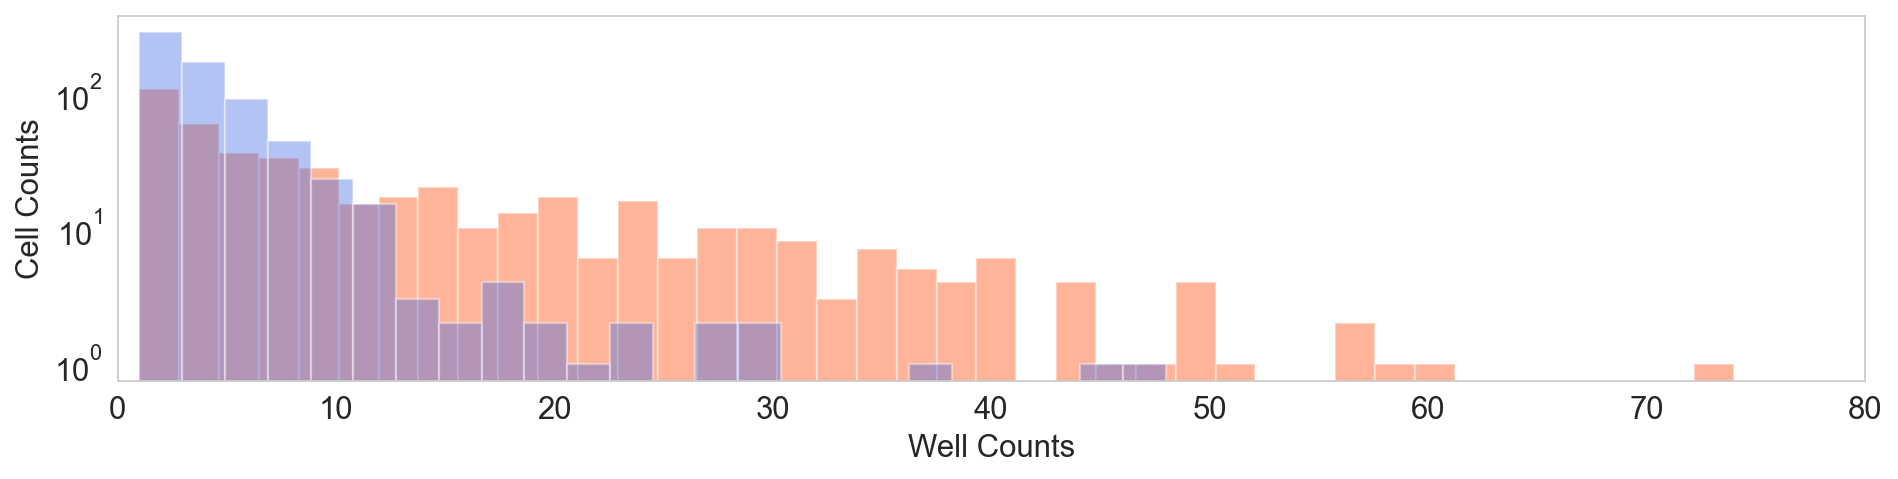

In [161]:
##plot cells per well
well_counts_M = adata_decontam[adata_decontam.obs.cell_call == 'M'].obs.groupby('barcode').size()

plt.rcParams['figure.figsize'] = [14, 3]

g = sns.distplot(well_counts_M,
             kde=False,
             bins=40,
             color='orangered'
            )

well_counts_H = adata_decontam[adata_decontam.obs.cell_call == 'H'].obs.groupby('barcode').size()


g = sns.distplot(well_counts_H,
             kde=False,
             bins=24,
             color='royalblue'
            )


g.set_yscale('log')
g.set_xlim(0,80)

g.set_ylabel('Cell Counts')
g.set_xlabel('Well Counts')

plt.grid(False)

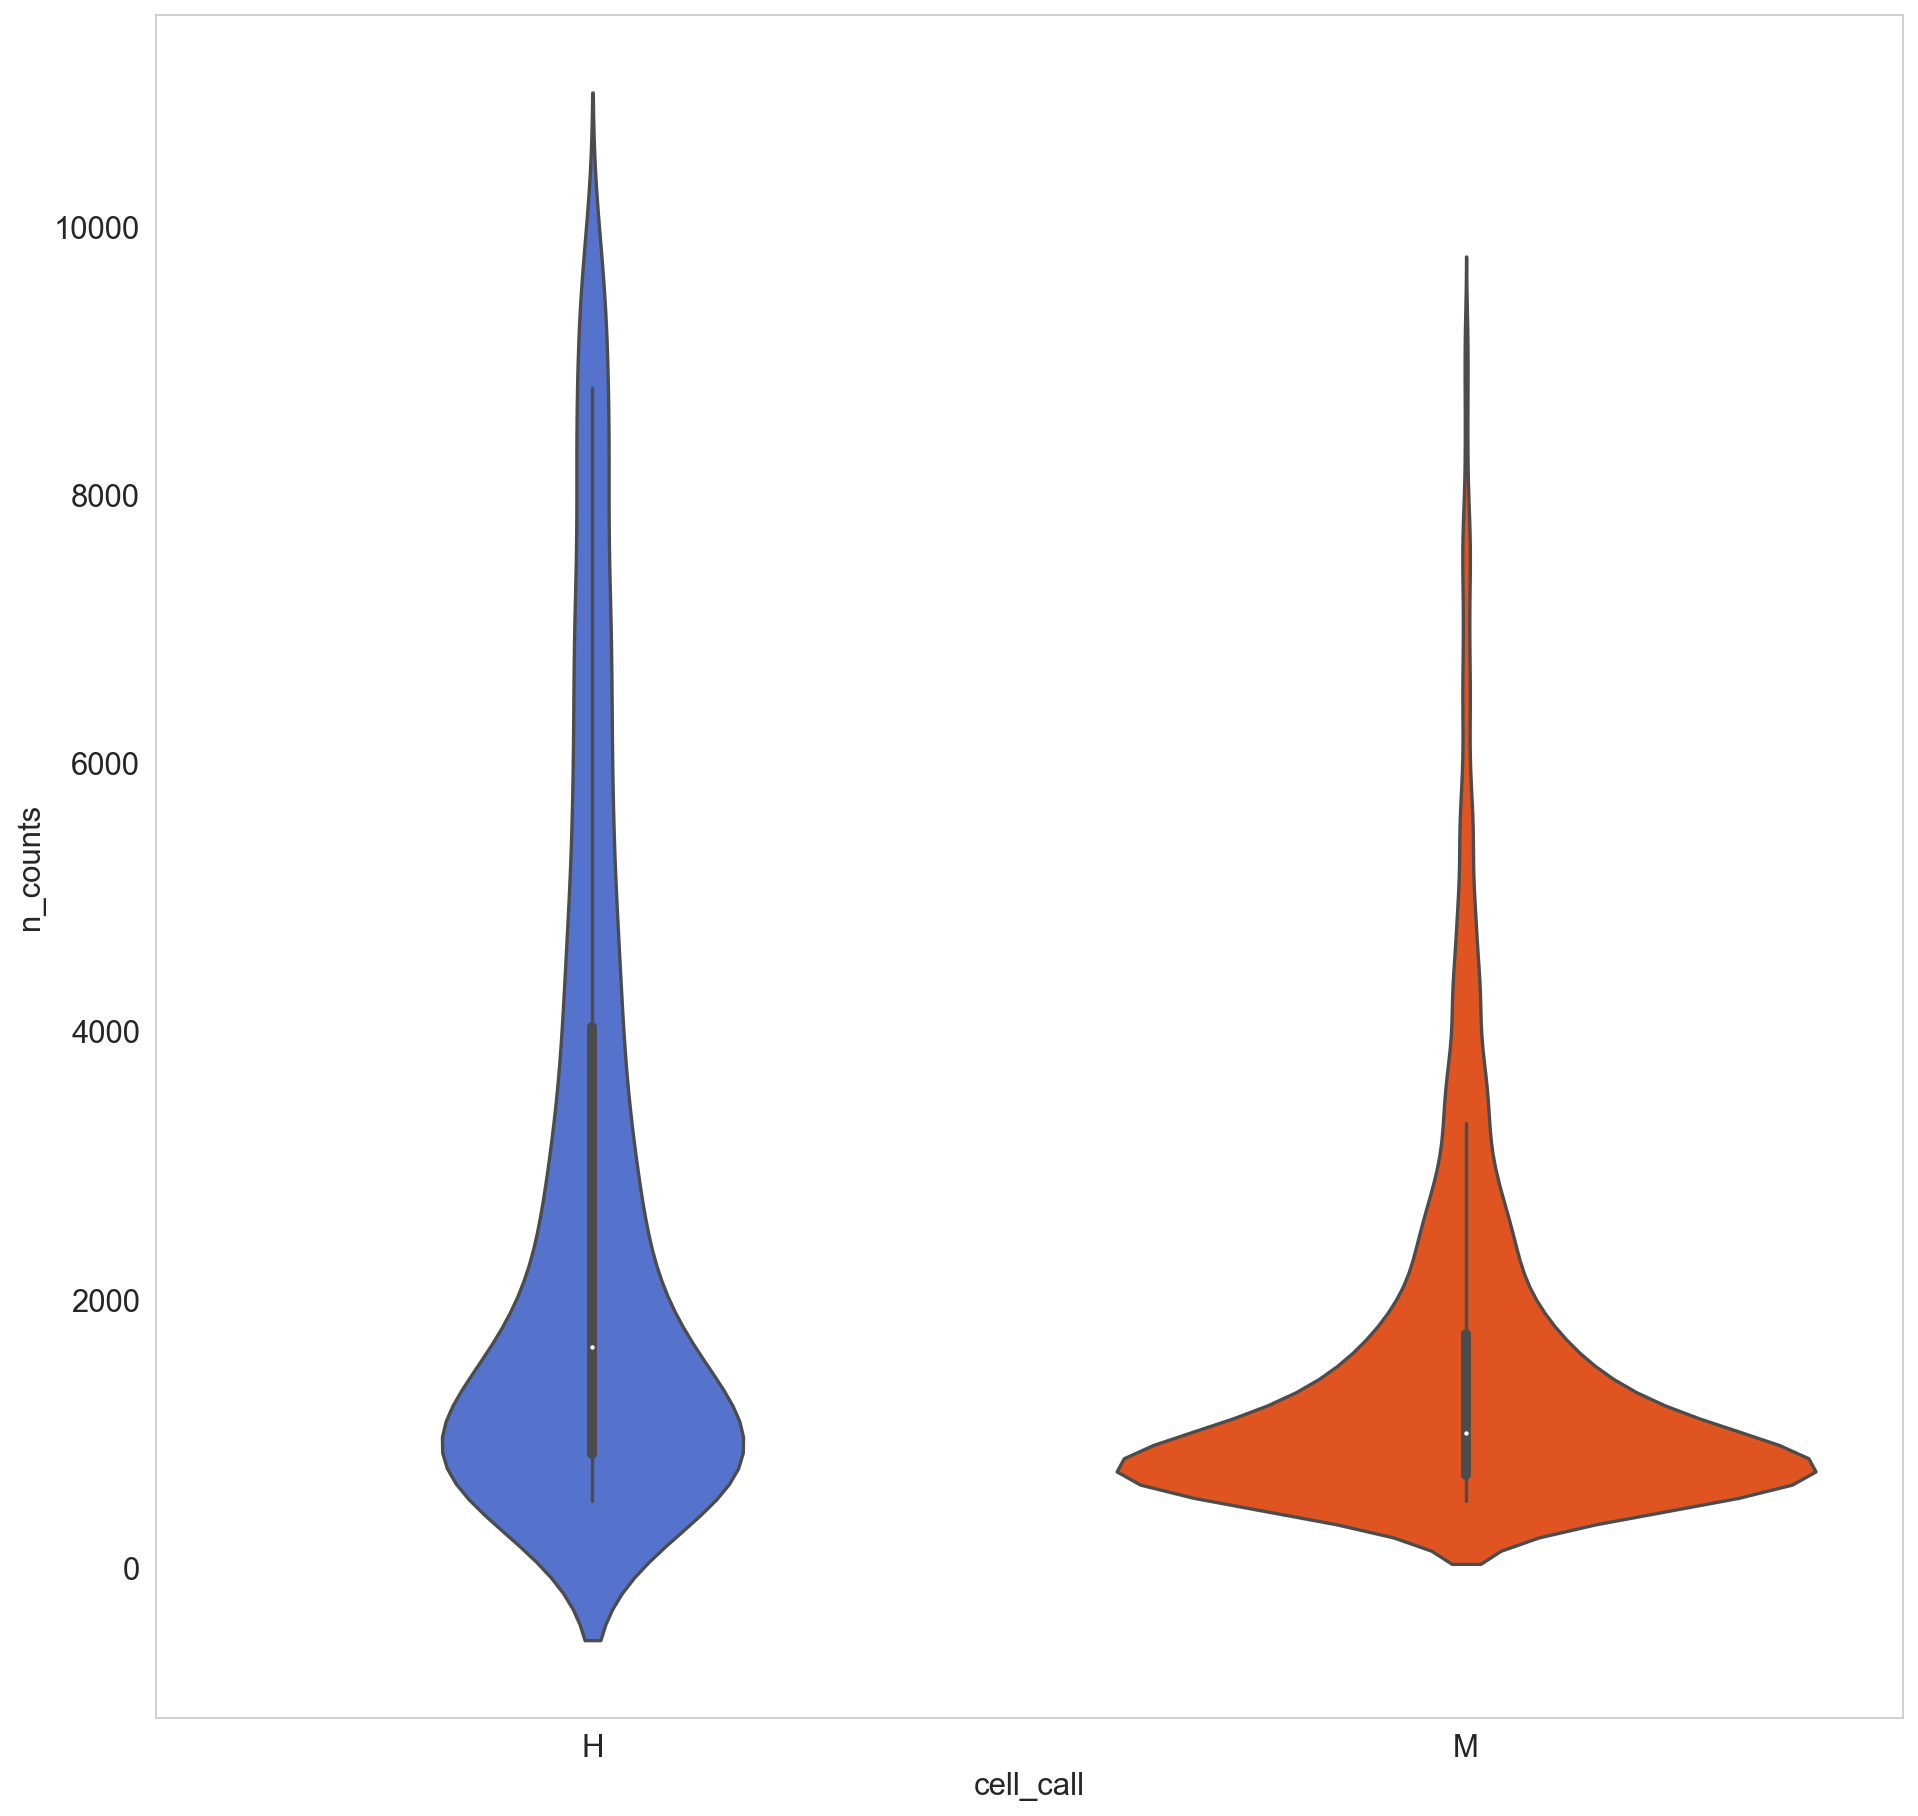

In [162]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata_decontam[adata_decontam.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered'],
              );



#plt.axis('off')
plt.grid(False)

In [163]:
print("median UMIs mouse: " + str(np.median(adata_decontam[adata_decontam.obs['cell_call']=='M'].obs.n_counts)))

print("median UMIs human: " + str(np.median(adata_decontam[adata_decontam.obs['cell_call']=='H'].obs.n_counts)))




median UMIs mouse: 1004.3546
median UMIs human: 1643.5747


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


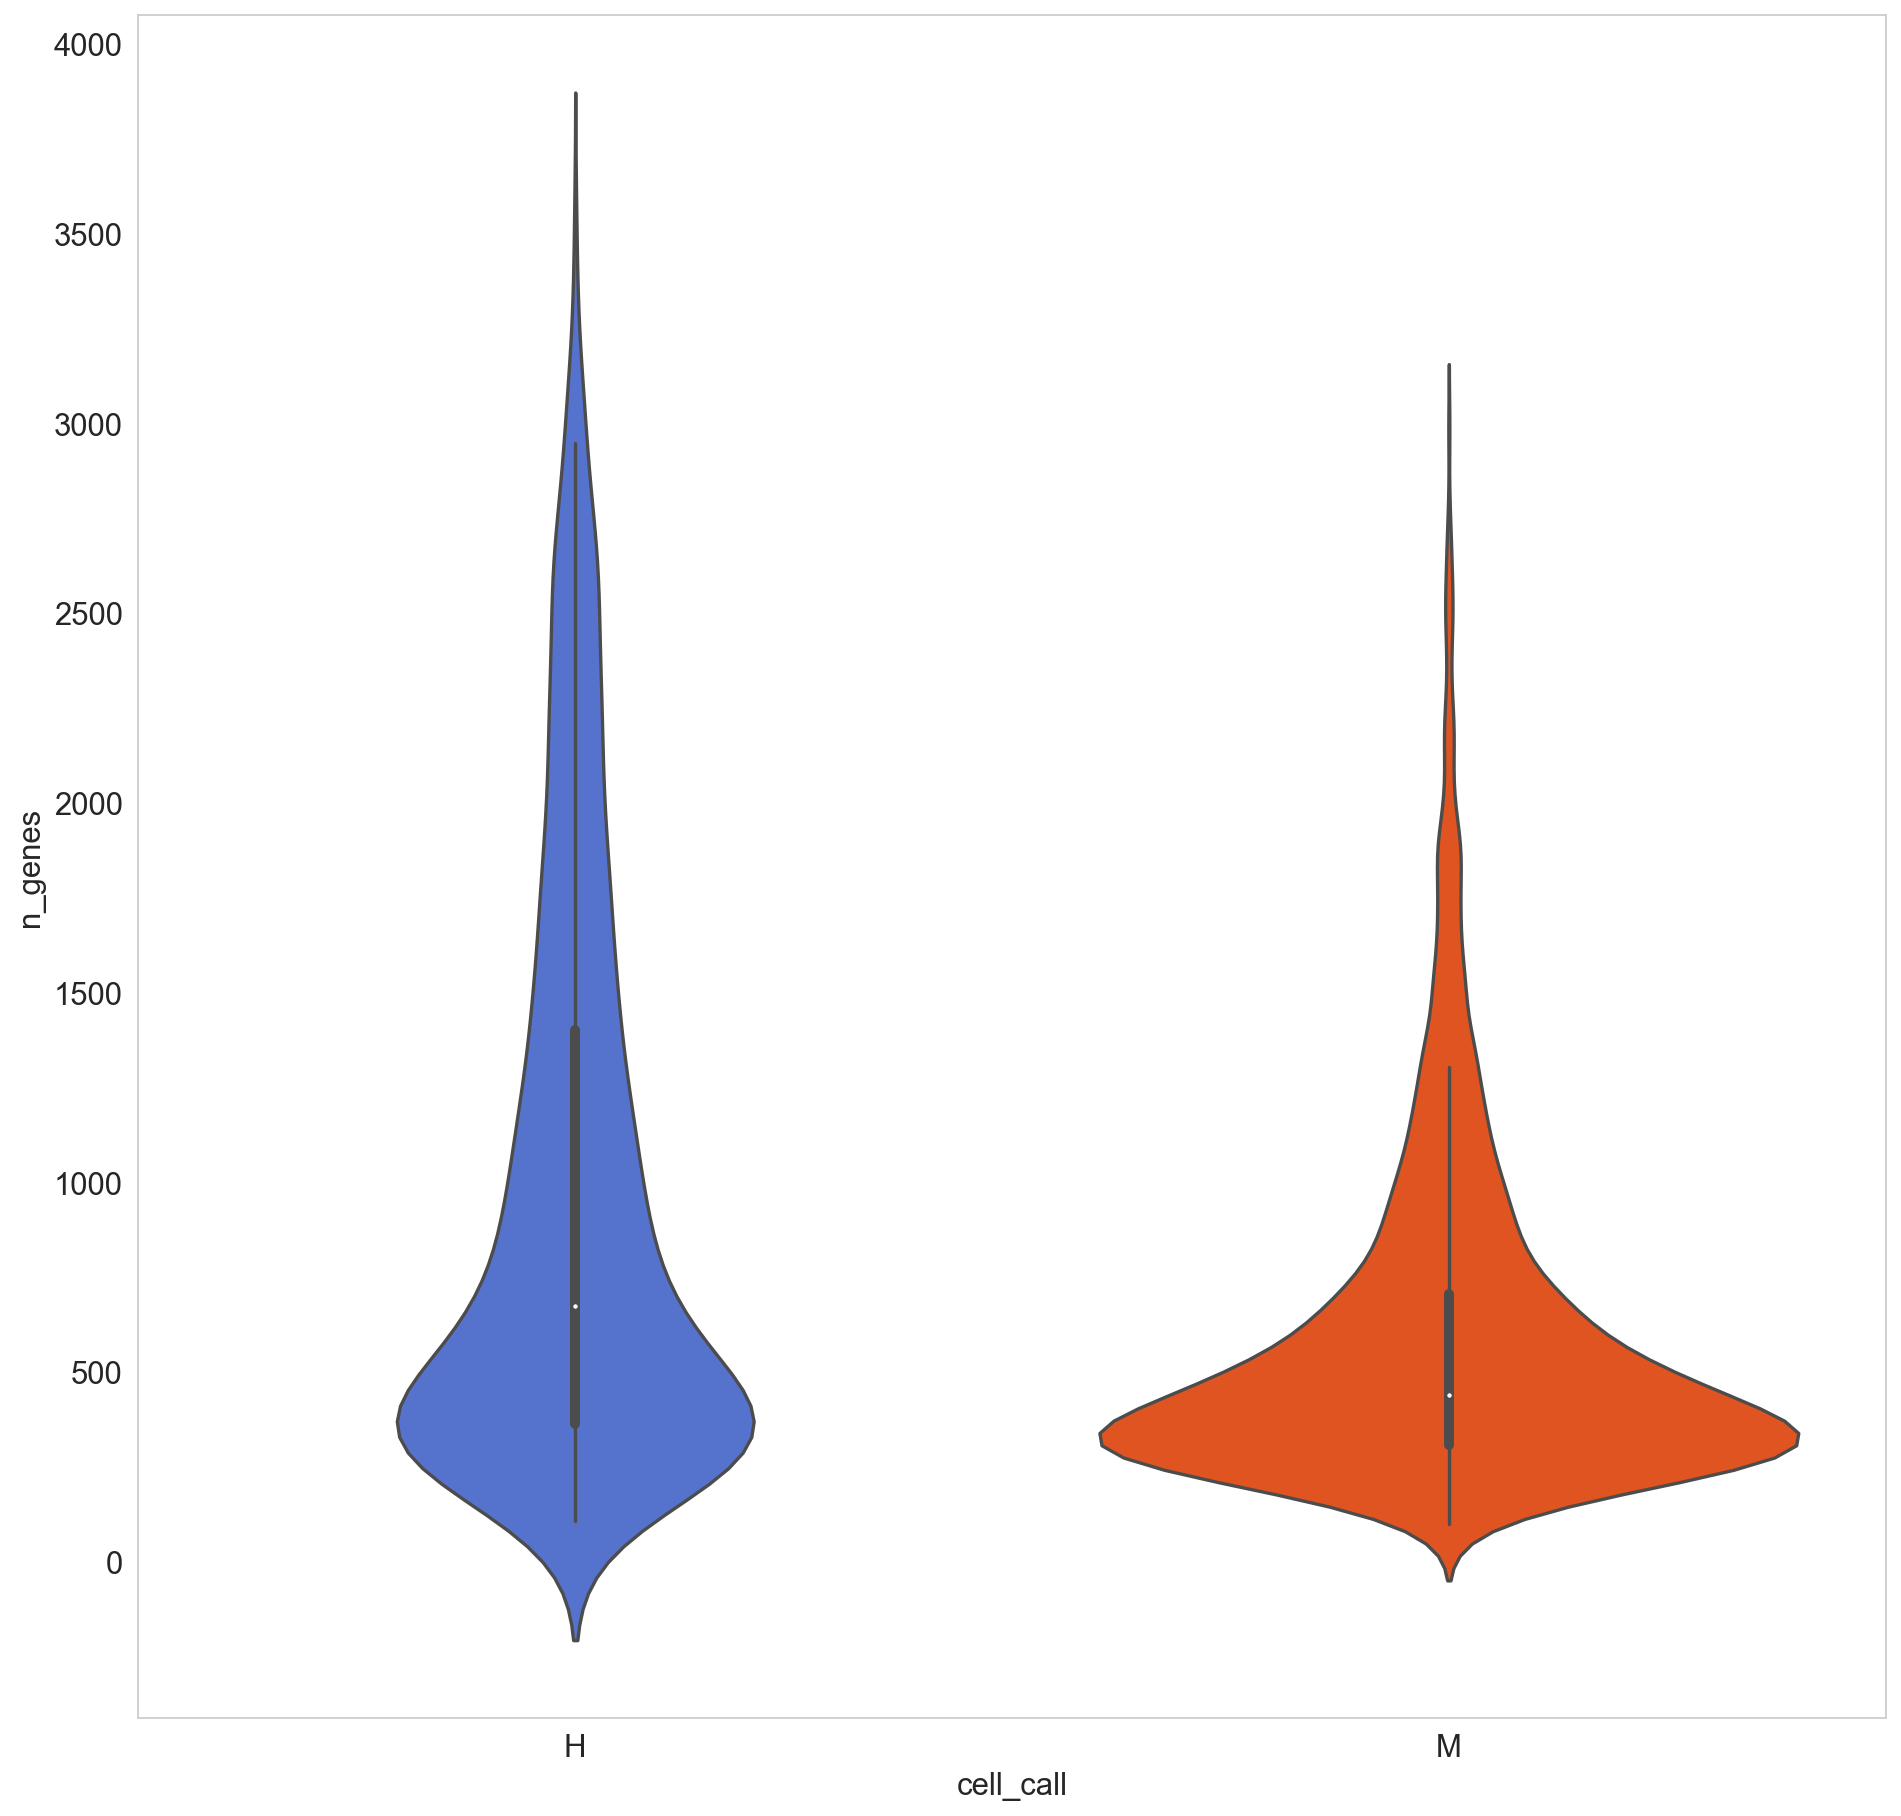

In [164]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata_decontam[adata_decontam.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

#plt.axis('off')
plt.grid(False) 

In [165]:
print("median genes mouse: " + str(np.median(adata_decontam[adata_decontam.obs['cell_call']=='M'].obs.n_genes)))

print("median genes human: " + str(np.median(adata_decontam[adata_decontam.obs['cell_call']=='H'].obs.n_genes)))


median genes mouse: 441.0
median genes human: 674.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
